In [3]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

### lvl 1 setups

import sys
sys.path.append('/portal1/dell/GitHub/WAYS')
sys.path.append('/portal1/dell/GitHub/sanctuary')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import hstack
from matplotlib import pyplot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from numpy import polyfit, poly1d
from stats import cr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [5]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from gistool import basemap, stack_image, stack_shp, stack_hatch, stack_shp_cn, ncslice
from spatial import upscale
import statsmodels.formula.api as smf
from scipy.stats.mstats import theilslopes
from scipy.stats import kendalltau
import cartopy.crs as ccrs

import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

import climate_indices as indices
from climate_indices import compute
from climate_indices import utils, indices

In [6]:
shp='/portal3/gis/LMRB_Boundary/Lancang_Mekong_Basin/Lancang_Mekong_Basin.shp'
dsp = xr.open_dataset('/home/wang-k/main/MLdrought/weekly_data/prec_weekly_lmrb.nc')
dspet = xr.open_dataset('/home/wang-k/main/MLdrought/weekly_data/pet_weekly_lmrb_penman.nc')

In [7]:
## choose prec wet season
dsp_wet=dsp.sel(time=((dsp.time.dt.month == 5) | (dsp.time.dt.month == 6) |
                      (dsp.time.dt.month == 7) | (dsp.time.dt.month == 8) |
                      (dsp.time.dt.month == 9) | (dsp.time.dt.month == 10)))

## choose prec dry season
dsp_dry=dsp.sel(time=((dsp.time.dt.month == 1) | (dsp.time.dt.month == 2) |
                      (dsp.time.dt.month == 3) | (dsp.time.dt.month == 4) |
                      (dsp.time.dt.month == 11) | (dsp.time.dt.month == 12)))

In [8]:
## choose pet wet season
dspet_wet=dspet.sel(time=((dspet.time.dt.month == 5) | (dspet.time.dt.month == 6) |
                      (dspet.time.dt.month == 7) | (dspet.time.dt.month == 8) |
                      (dspet.time.dt.month == 9) | (dspet.time.dt.month == 10)))

## choose pet dry season
dspet_dry=dspet.sel(time=((dspet.time.dt.month == 1) | (dspet.time.dt.month == 2) |
                      (dspet.time.dt.month == 3) | (dspet.time.dt.month == 4) |
                      (dspet.time.dt.month == 11) | (dspet.time.dt.month == 12)))

In [9]:
def replace_negative_with_zero(arr):
    return np.maximum(arr, 0)
dspwet_data = replace_negative_with_zero(dsp_wet.tp.values)
dspdry_data = replace_negative_with_zero(dsp_dry.tp.values)
petwet_data = dspet_wet.pev.values
petdry_data = dspet_dry.pev.values

# SPEI in dry and wet season weekly

In [10]:
# using climate indices package calculate SPEI wet season
import climate_indices as indices
from climate_indices import compute
from climate_indices import utils, indices

spei_w = np.empty((1638, 102, 61))
for i in range(0,102):
    for j in range(0,61):
        speiw = indices.spei(precips_mm=dspwet_data[:,i,j],
                            pet_mm=petwet_data[:,i,j],
                            scale=1,
                            distribution=indices.Distribution.gamma,
                            periodicity=compute.Periodicity.daily,
                            data_start_year=1960,
                            calibration_year_initial=1960,
                            calibration_year_final=2022)
        spei_w[:, i, j] = speiw

In [11]:
# using climate indices package calculate SPEI wet season
import climate_indices as indices
from climate_indices import compute
from climate_indices import utils, indices

spei_d = np.empty((1638, 102, 61))
for i in range(0,102):
    for j in range(0,61):
        speid = indices.spei(precips_mm=dspdry_data[:,i,j],
                            pet_mm=petdry_data[:,i,j],
                            scale=1,
                            distribution=indices.Distribution.gamma,
                            periodicity=compute.Periodicity.daily,
                            data_start_year=1960,
                            calibration_year_initial=1960,
                            calibration_year_final=2022)
        spei_d[:, i, j] = speid

# Total drought (SPEI < -1.28)

## dry season 

In [12]:
count_dryd = []
for y in range (0,63):
    for i in range(0,102):
        for j in range(0,61):
            array = spei_d[y*26:(y+1)*26, i, j]
            if np.isnan(array[0]):
                count_dryd.append(np.nan)
            else :
                count_dryd.append(np.sum(array < -1.28))
count_dryd = np.array(count_dryd).reshape(63,102,61)

In [13]:
count_wetd = []
for y in range (0,63):
    for i in range(0,102):
        for j in range(0,61):
            array = spei_w[y*26:(y+1)*26, i, j]
            if np.isnan(array[0]):
                count_wetd.append(np.nan)
            else :
                count_wetd.append(np.sum(array < -1.28))
count_wetd = np.array(count_wetd).reshape(63,102,61)

In [14]:
count_totald = count_wetd + count_dryd

# Flash Drought (SPEI < -1.28 & ΔSPEI < -2 within four weeks)

### flash drought in dry season

In [15]:
count_dryfd = []

for m in range(63):
    start_idx = m * 26
    end_idx = (m + 1) * 26
    for i in range(0, 102):
        for j in range(0, 61): 
            array = spei_d[:, i, j]
            b = 0
            k = start_idx
            if np.isnan(array[0]):
                count_dryfd.append(np.nan)
            else:    
                while k < end_idx:
                    for n in range(1, 5):
                        if k >= n and array[k] <= -1.28 and array[k] - array[k - n] <= -2:
                            b += 1
                            k += 1
                            break
                    else:
                        k += 1
                        continue

                    for a in range(k, end_idx):
                        if array[a] < -1.28:
                            b += 1
                            k += 1
                        else:
                            break

                count_dryfd.append(b)
count_dryfd = np.array(count_dryfd).reshape(63,102,61)


### flash drought in wet season

In [16]:
count_wetfd = []

for m in range(63):
    start_idx = m * 26
    end_idx = (m + 1) * 26
    for i in range(0, 102):
        for j in range(0, 61): 
            array = spei_w[:, i, j]
            b = 0
            k = start_idx
            if np.isnan(array[0]):
                count_wetfd.append(np.nan)
            else:    
                while k < end_idx:
                    for n in range(1, 5):
                        if k >= n and array[k] <= -1.28 and array[k] - array[k - n] <= -2:
                            b += 1
                            k += 1
                            break
                    else:
                        k += 1
                        continue

                    for a in range(k, end_idx):
                        if array[a] < -1.28:
                            b += 1
                            k += 1
                        else:
                            break

                count_wetfd.append(b)
count_wetfd = np.array(count_wetfd).reshape(63,102,61)


In [17]:
count_totalfd = count_wetfd + count_dryfd

# plot spatial temporal trend

## plot the drought events during 1960-2022 spatially

In [18]:
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
clist1 =['#ffffff','#f8ad9d','#3a20f0']
red1 = LinearSegmentedColormap.from_list('chaos',clist1)
clist2 =['#fffdf7','#99d6ea','#6798c0','#f0a7a0','#f26ca7']
cmap2 = LinearSegmentedColormap.from_list('chaos',clist2)
clist4 =['#fffdf7','#99d6ea','#6798c0','#f0a7a0','#f26ca7','#a019a6']
cmap4 = LinearSegmentedColormap.from_list('chaos',clist4)


In [19]:
total_fd = np.nanmean(count_totalfd,axis=0)
total_d = np.nanmean(count_totald,axis=0)
wet_fd = np.nanmean(count_wetfd,axis=0)
wet_d = np.nanmean(count_wetd,axis=0)
dry_fd = np.nanmean(count_dryfd,axis=0)
dry_d = np.nanmean(count_dryd,axis=0)

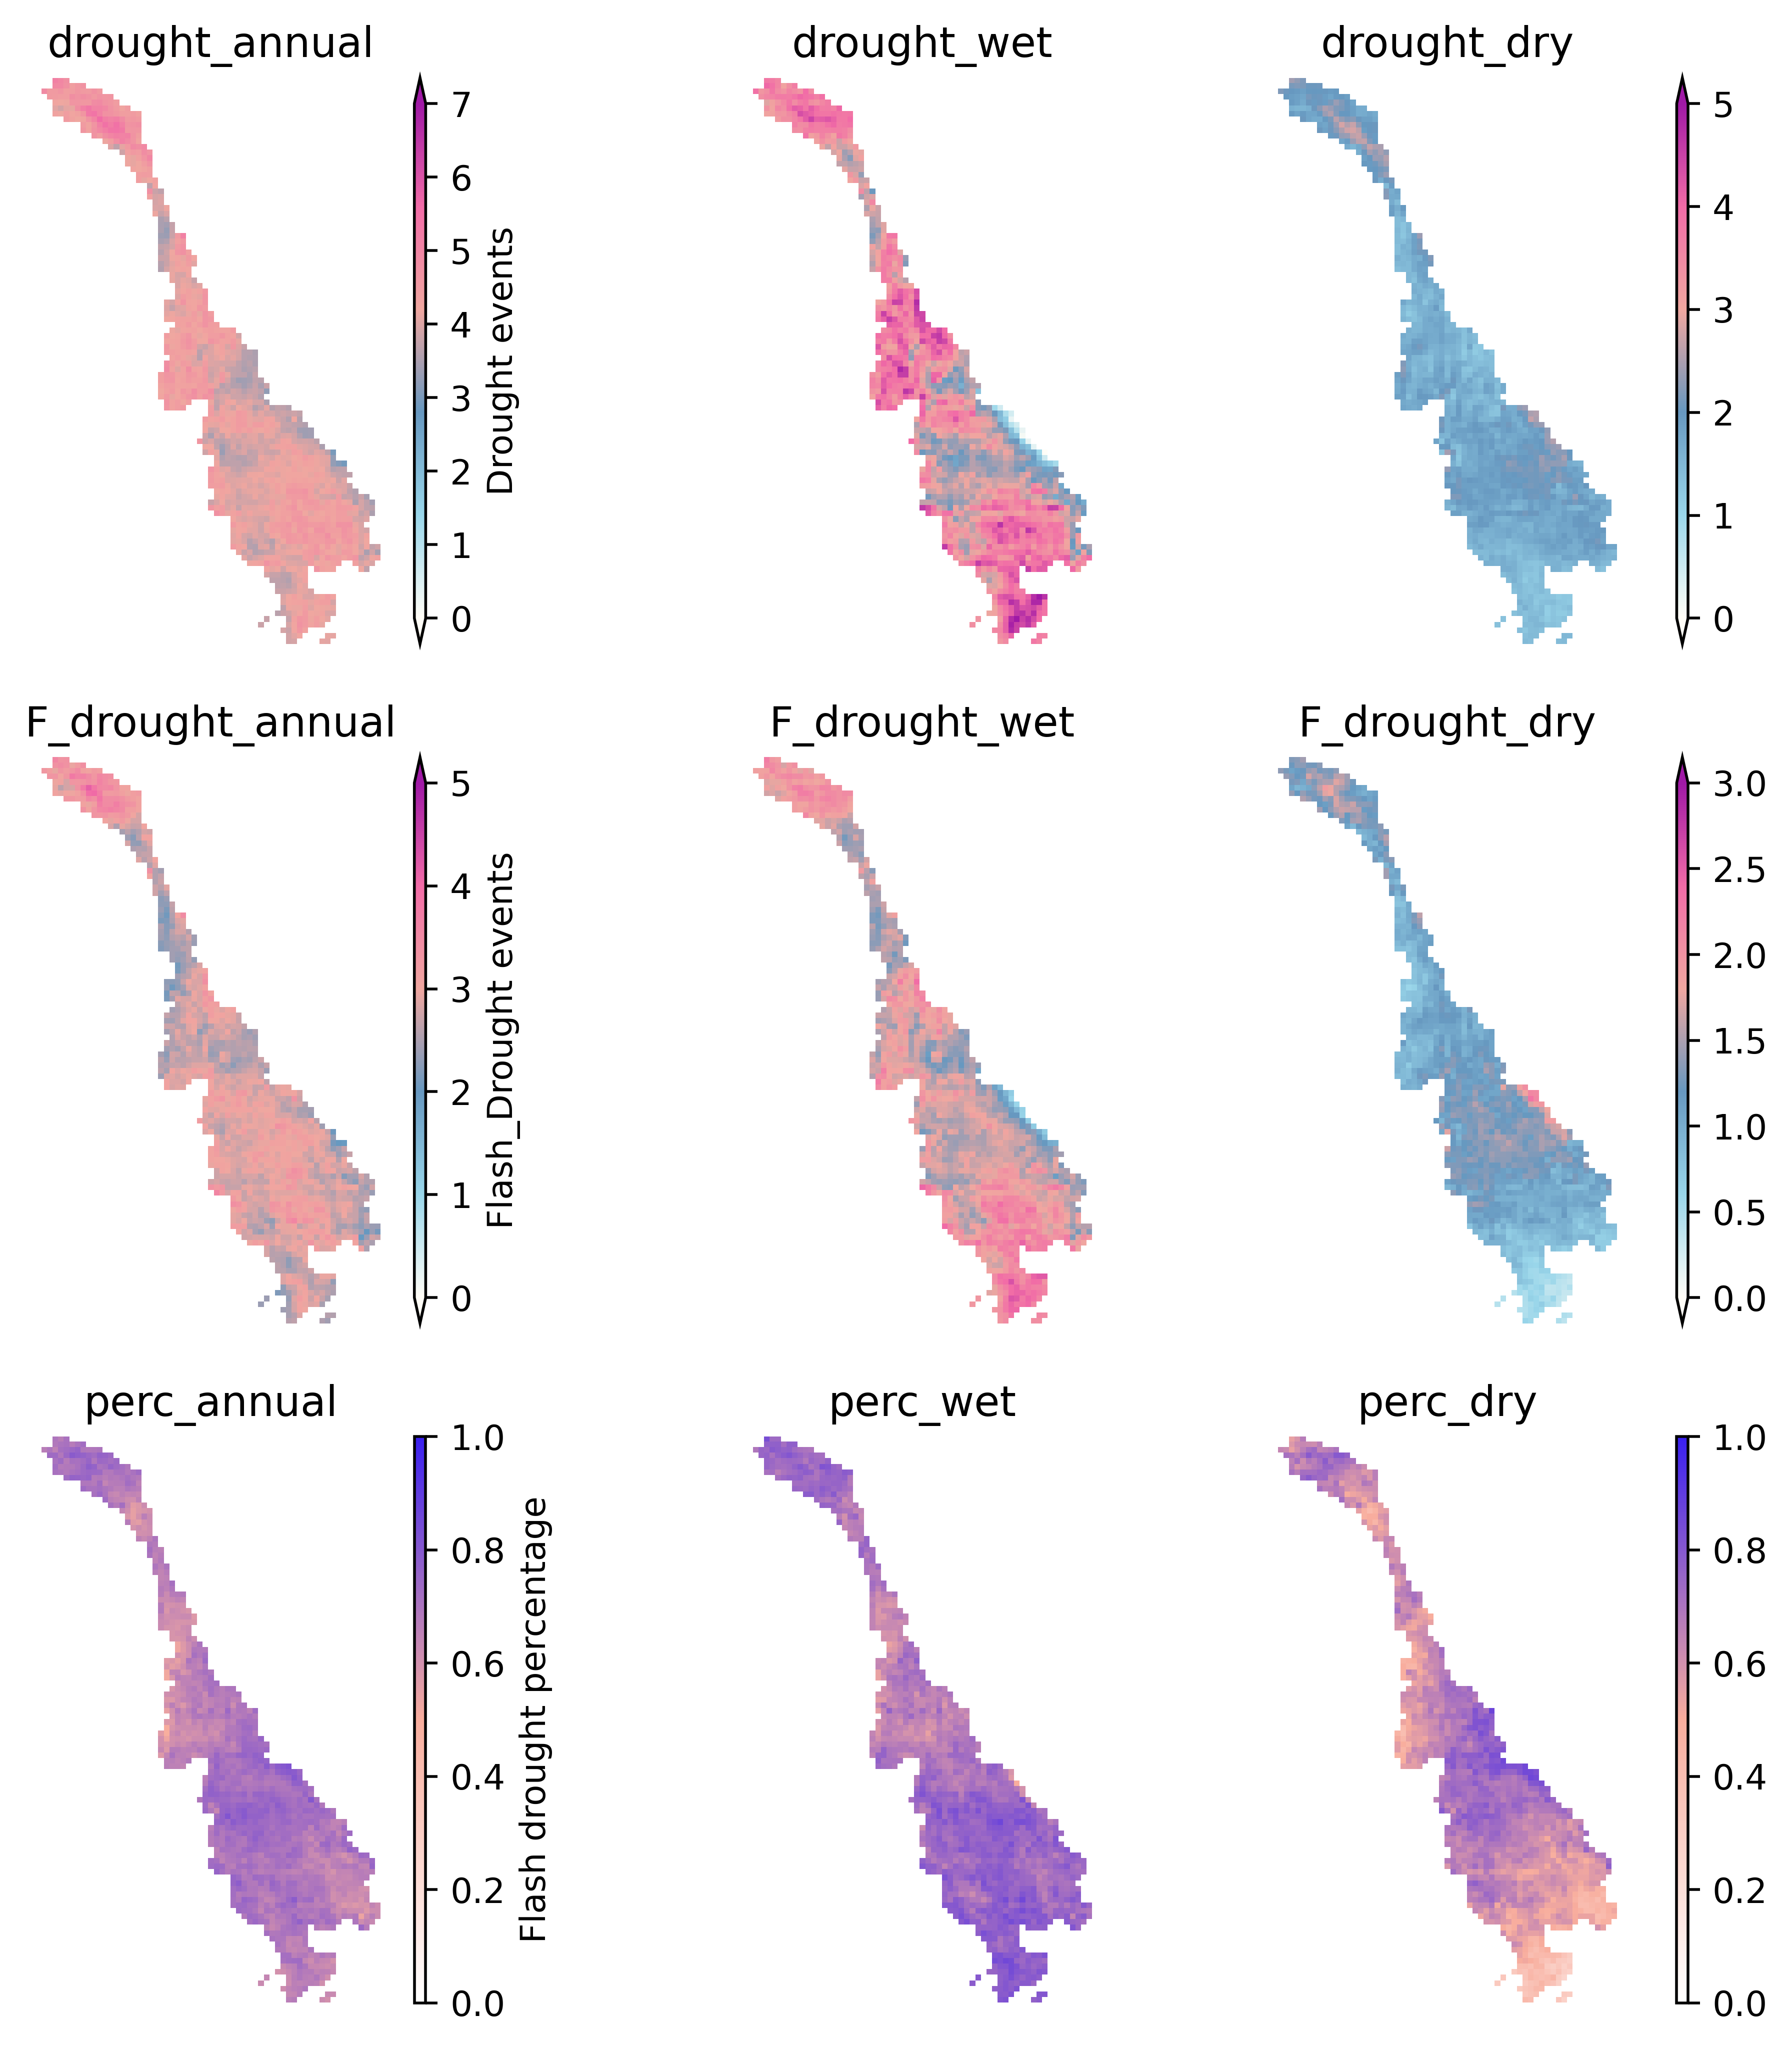

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(12, 10), dpi=500)
images = []

namess = ['drought_annual', 'drought_wet', 'drought_dry',
          'F_drought_annual', 'F_drought_wet', 'F_drought_dry',
          'perc_annual', 'perc_wet', 'perc_dry']

varia = [total_d, wet_d, dry_d,
         total_fd, wet_fd, dry_fd,
         total_fd / total_d, wet_fd / wet_d, dry_fd / dry_d]

for i, (qt, subplot, name) in enumerate(zip(varia, ax.flat, namess)):
    im = subplot.imshow(qt, cmap=cmap4, interpolation='nearest')
    images.append(im)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_frame_on(False)
    ax[-1, -1].axis('off')
    subplot.set_title(name)

    if i == 0:
        cbar = fig.colorbar(im, ax=subplot, location='right', shrink=1, aspect=50, extend='both')
        cbar.set_label('Drought events')
        im.set_clim(vmin=0, vmax=7)
    elif i == 1 or i == 2:
        cbar = fig.colorbar(im, ax=ax[0, 1:], location='right', shrink=1, aspect=50, extend='both')
        if i == 2:
            # cbar.set_label('Drought events in wet and dry season')
            im.set_clim(vmin=0, vmax=5)
        if i == 1:
            cbar.remove()
    elif i == 3:
        cbar = fig.colorbar(im, ax=subplot, location='right', shrink=1, aspect=50, extend='both')
        cbar.set_label('Flash_Drought events')
        im.set_clim(vmin=0, vmax=5)
    elif i == 4 or i == 5:
        cbar = fig.colorbar(im, ax=ax[1, 1:], location='right', shrink=1, aspect=50, extend='both')
        if i == 5:
            pass
            # cbar.set_label('F_Drought events in wet and dry season')
        if i == 4:
            cbar.remove()
        im.set_clim(vmin=0, vmax=3)
    elif i == 6:
        cbar = fig.colorbar(im, ax=subplot, location='right', shrink=1, aspect=50,)
        cbar.set_label('Flash drought percentage')
        im.set_clim(vmin=0, vmax=1)
    elif i == 7 or i == 8:
        cbar = fig.colorbar(im, ax=ax[2, 1:], location='right', shrink=1, aspect=50)
        if i == 8:
            pass
            # cbar.set_label('F_drought percentage in wet and dry season')
        im.set_clim(vmin=0, vmax=1)
        if i == 7:
            cbar.remove()

# 修改配色为'Reds'
for im in images[6:]:
    im.set_cmap(red1)

plt.show()


## plot the drought events during 1960-2022 boxplot

In [21]:
VVV = [count_totald,count_wetd,count_dryd,count_totalfd,count_wetfd,count_dryfd]
varia = [total_d, wet_d, dry_d,
         total_fd, wet_fd, dry_fd,
         total_fd / total_d, wet_fd / wet_d, dry_fd / dry_d]

In [22]:
total_d_box = total_d.reshape(102*61)[~np.isnan(total_d.reshape(102*61))] 
wet_d_box = wet_d.reshape(102*61)[~np.isnan(wet_d.reshape(102*61))] 
dry_d_box = dry_d.reshape(102*61)[~np.isnan(dry_d.reshape(102*61))] 

total_fd_box = total_fd.reshape(102*61)[~np.isnan(total_fd.reshape(102*61))] 
wet_fd_box = wet_fd.reshape(102*61)[~np.isnan(wet_fd.reshape(102*61))] 
dry_fd_box = dry_fd.reshape(102*61)[~np.isnan(dry_fd.reshape(102*61))] 

perc_anual_box = total_fd_box/total_d_box
perc_wet_box = wet_fd_box/wet_d_box
perc_dry_box = dry_fd_box/dry_d_box


data_drought = [total_d_box, wet_d_box, dry_d_box]
data_fdrought = [total_fd_box, wet_fd_box, dry_fd_box]
data_perc = [perc_anual_box, perc_wet_box, perc_dry_box]

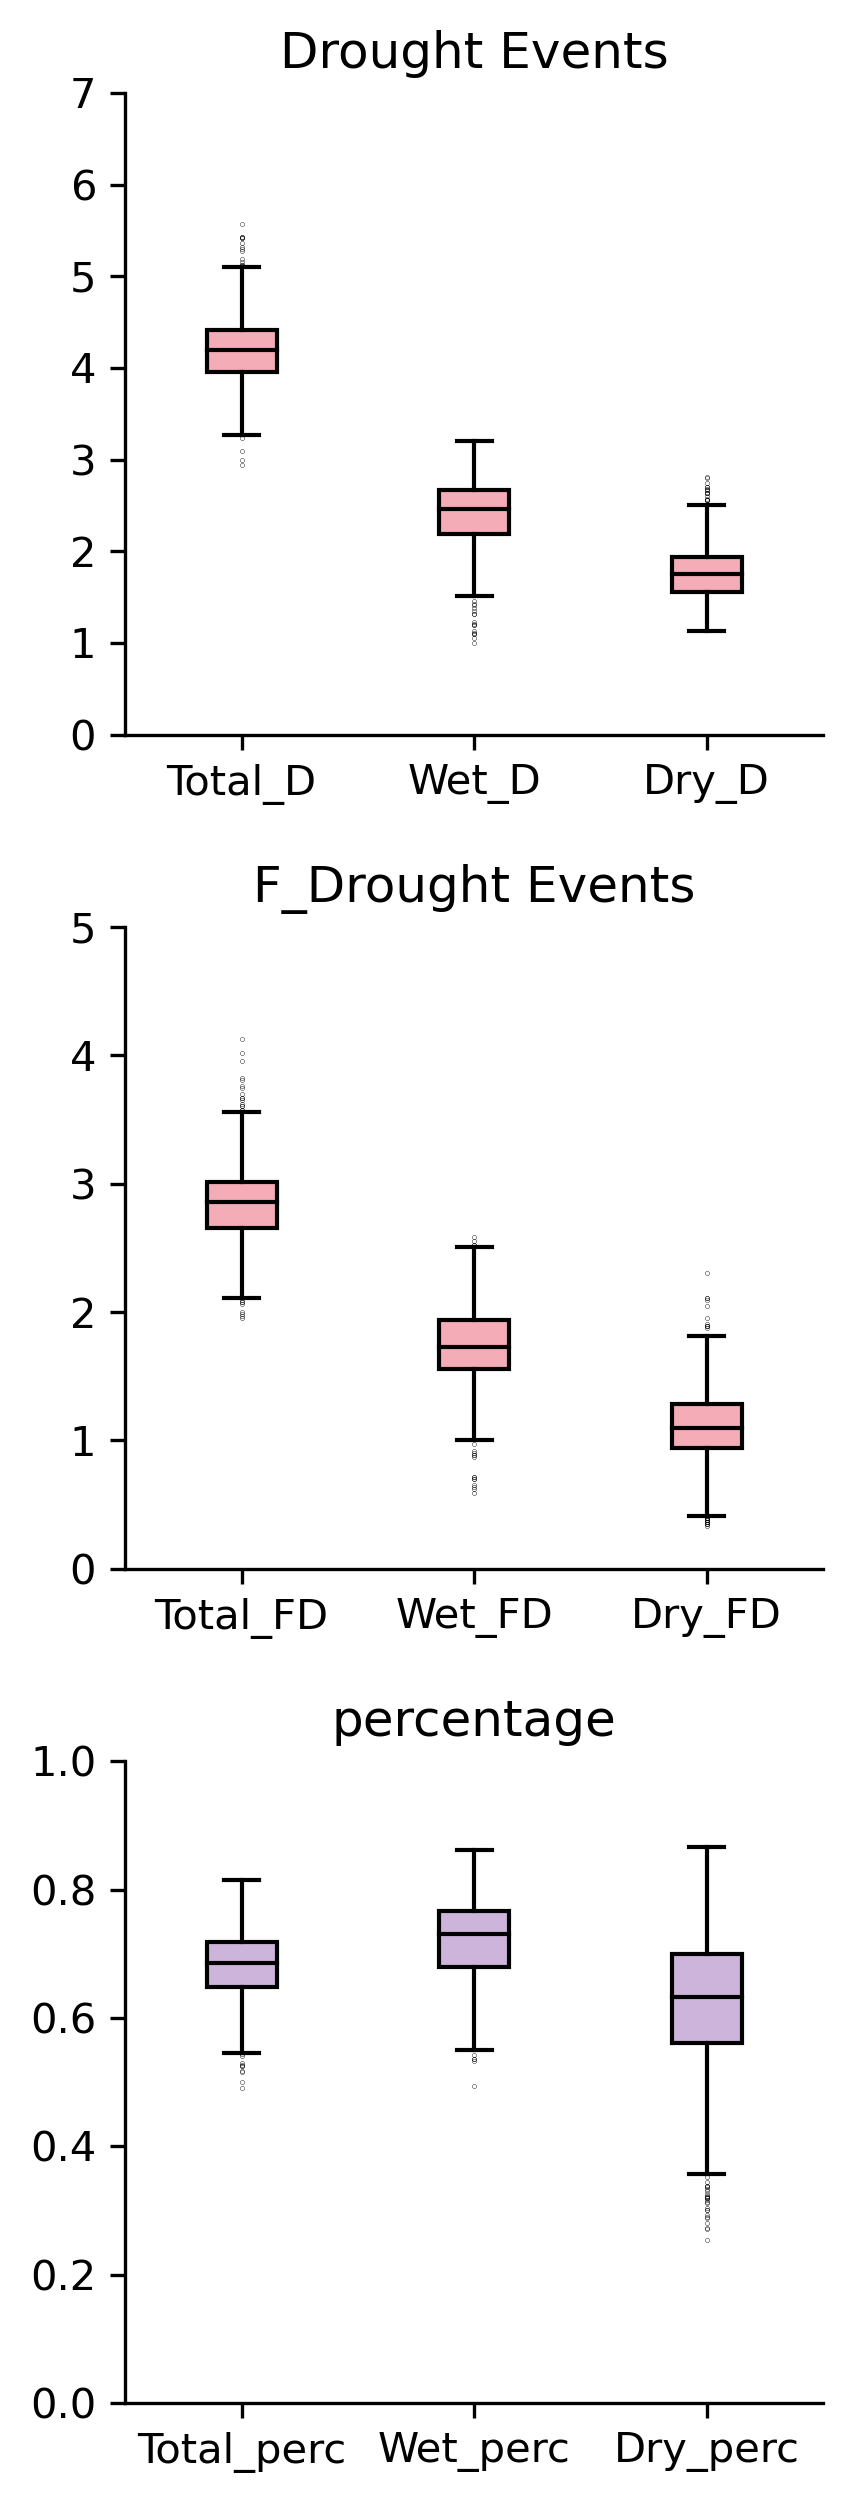

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(3, 10), gridspec_kw={'hspace': 0.3}, dpi=300)

# Plot the box plots in each figure
axes[0].boxplot(data_drought,
                flierprops=dict(marker='.', markersize=0.2),
                boxprops={'facecolor': '#f4acb7', 'color': 'k'},            
                medianprops={'color': 'k'},
                patch_artist=True)
axes[0].set_title('Drought Events')
axes[0].set_xticklabels(['Total_D', 'Wet_D', 'Dry_D'])
axes[0].set_ylim([0, 7])

axes[1].boxplot(data_fdrought, 
                flierprops=dict(marker='.', markersize=0.2),
                boxprops={'facecolor': '#f4acb7', 'color': 'k'},
                medianprops={'color': 'k'},
                patch_artist=True)
axes[1].set_title('F_Drought Events')
axes[1].set_xticklabels(['Total_FD', 'Wet_FD', 'Dry_FD'])
axes[1].set_ylim([0, 5])

axes[2].boxplot(data_perc, 
                flierprops=dict(marker='.', markersize=0.2),
                boxprops={'facecolor': '#cdb4db', 'color': 'k'},
                medianprops={'color': 'k'},
                patch_artist=True)
axes[2].set_title('percentage')
axes[2].set_xticklabels(['Total_perc', 'Wet_perc', 'Dry_perc'])
axes[2].set_ylim([0, 1])


axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()

# temporal distubution of drought events

In [24]:
VVV = [count_totald,count_wetd,count_dryd,count_totalfd,count_wetfd,count_dryfd]
varia = [total_d, wet_d, dry_d,
         total_fd, wet_fd, dry_fd,
         total_fd / total_d, wet_fd / wet_d, dry_fd / dry_d]

In [25]:
total_yd = np.nanmean(count_totald,axis=(1,2))
wet_yd = np.nanmean(count_wetd,axis=(1,2))
dry_yd = np.nanmean(count_dryd,axis=(1,2))
total_yfd = np.nanmean(count_totalfd,axis=(1,2))
wet_yfd = np.nanmean(count_wetfd,axis=(1,2))
dry_yfd = np.nanmean(count_dryfd,axis=(1,2))
vari2 = [total_yd, wet_yd, dry_yd,total_yfd, wet_yfd, dry_yfd,
         total_yfd / total_yd, wet_yfd / wet_yd, dry_yfd / dry_yd]

namess2 = ['drought_annual', 'drought_wet', 'drought_dry',
          'F_drought_annual', 'F_drought_wet', 'F_drought_dry',
          'perc_annual', 'perc_wet', 'perc_dry']

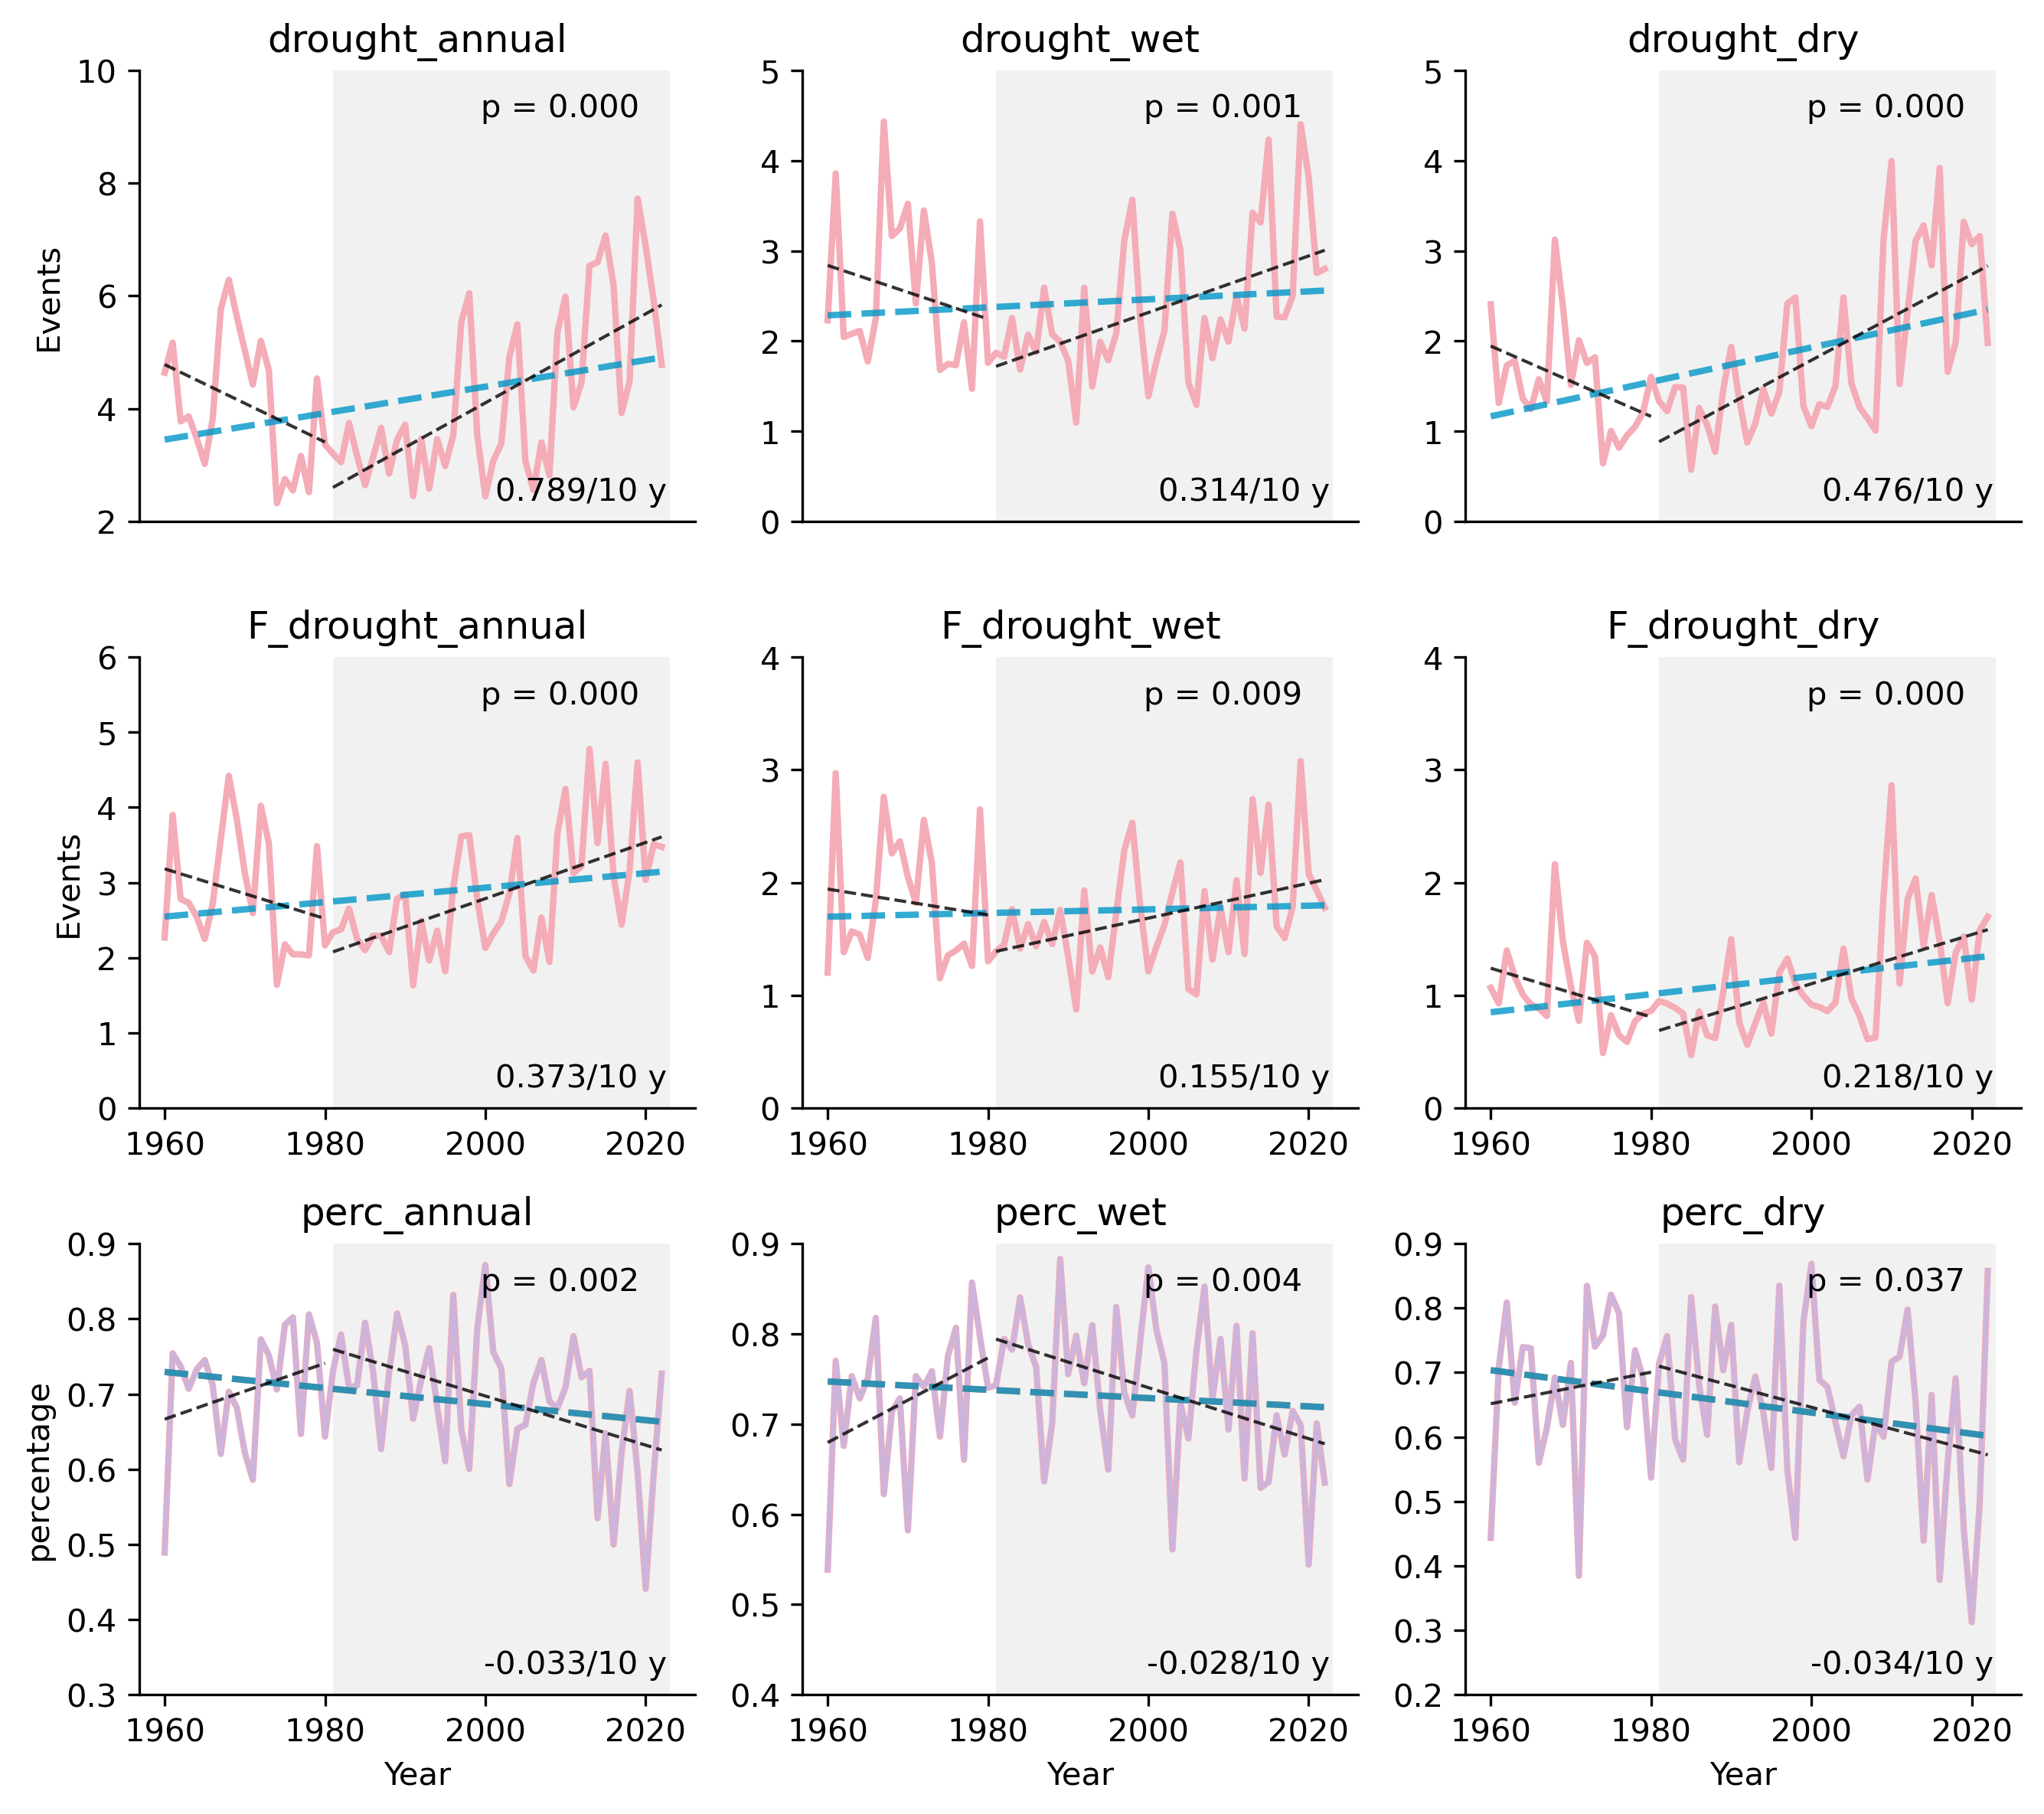

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
fig, axes = plt.subplots(3, 3, figsize=(9, 8), dpi=300)

for i, ax in enumerate(axes.flat):
    data = vari2[i]
    ax.plot(data,color="#f4acb7",lw=2)
    ax.set_title(namess2[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])  
    x = np.arange(len(data))
    x1 = np.arange(0,21)
    x2 = np.arange(21,63)
    slope, intercept, r_value, p_value, std_err = linregress(x, data)
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x1, data[0:21])
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x2, data[21:63])
    ax.axvspan(21, 63, facecolor='lightgray', alpha=0.3)

    ax.text(0.95, 0.1, f'{slope2*10:.3f}/10 y', ha='right', va='top', transform=ax.transAxes)
    
    if p_value2 < 0.05:
        ax.text(0.90, 0.95, f'p = {p_value2:.3f}', ha='right', va='top', transform=ax.transAxes)
    
    
    if i == 0:
        ax.set_ylim(2, 10)  
        ax.set_ylabel('Events') 
    elif i == 1:
        ax.set_ylim(0, 5)  
        ax.spines['right'].set_visible(False)
    elif i == 2:
        ax.set_ylim(0, 5)
    elif i == 3:
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
        ax.set_ylim(0, 6)
        ax.set_ylabel('Events')
    elif i == 4:
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
        ax.set_ylim(0, 4)
    elif i == 5:
        ax.set_ylim(0, 4)
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
    elif i == 6:
        ax.set_ylim(0.3, 0.9) 
        ax.set_xlabel('Year')
        ax.set_ylabel('percentage')
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
        ax.plot(data, color="#cdb4db")
        ax.plot(x, intercept + slope * x, color='#f06543', linestyle='--',lw= 2,alpha=0.8)
    elif i == 7:
        ax.set_ylim(0.4, 0.9)
        ax.set_xlabel('Year')  
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
        ax.plot(data, color="#cdb4db")
        ax.plot(x, intercept + slope * x, color='#f06543', linestyle='--',lw= 2,alpha=0.8)
        
    elif i == 8:
        ax.set_ylim(0.2, 0.9)
        ax.set_xlabel('Year')  
        ax.set_xticks([0, 20, 40, 60])  
        ax.set_xticklabels(['1960',  '1980', '2000', '2020'])  
        ax.plot(data, color="#cdb4db")
        ax.plot(x, intercept + slope * x, color='#f06543', linestyle='--',lw= 2,alpha=0.8)
    ax.plot(x, intercept + slope * x, color='#0096c7', linestyle='--',lw= 2,alpha=0.8)
    ax.plot(x1, intercept1 + slope1 * x1, color='k', linestyle='--',lw= 1,alpha=0.8)
    ax.plot(x2, intercept2 + slope2 * x2, color='k', linestyle='--',lw= 1,alpha=0.8)
plt.tight_layout()
plt.show()



# latitude distubution of drought events

In [27]:
total_lad = np.nanmean(count_totald,axis=(0,2))
wet_lad = np.nanmean(count_wetd,axis=(0,2))
dry_lad = np.nanmean(count_dryd,axis=(0,2))
total_lafd = np.nanmean(count_totalfd,axis=(0,2))
wet_lafd = np.nanmean(count_wetfd,axis=(0,2))
dry_lafd = np.nanmean(count_dryfd,axis=(0,2))
vari3 = [total_lad, wet_lad, dry_lad,total_lafd, wet_lafd, dry_lafd,
         total_lafd / total_lad, wet_lafd / wet_lad, dry_lafd / dry_lad]

namess3 = ['drought_annual', 'drought_wet', 'drought_dry',
          'F_drought_annual', 'F_drought_wet', 'F_drought_dry',
          'perc_annual', 'perc_wet', 'perc_dry']

In [28]:
count_totald.shape

(63, 102, 61)

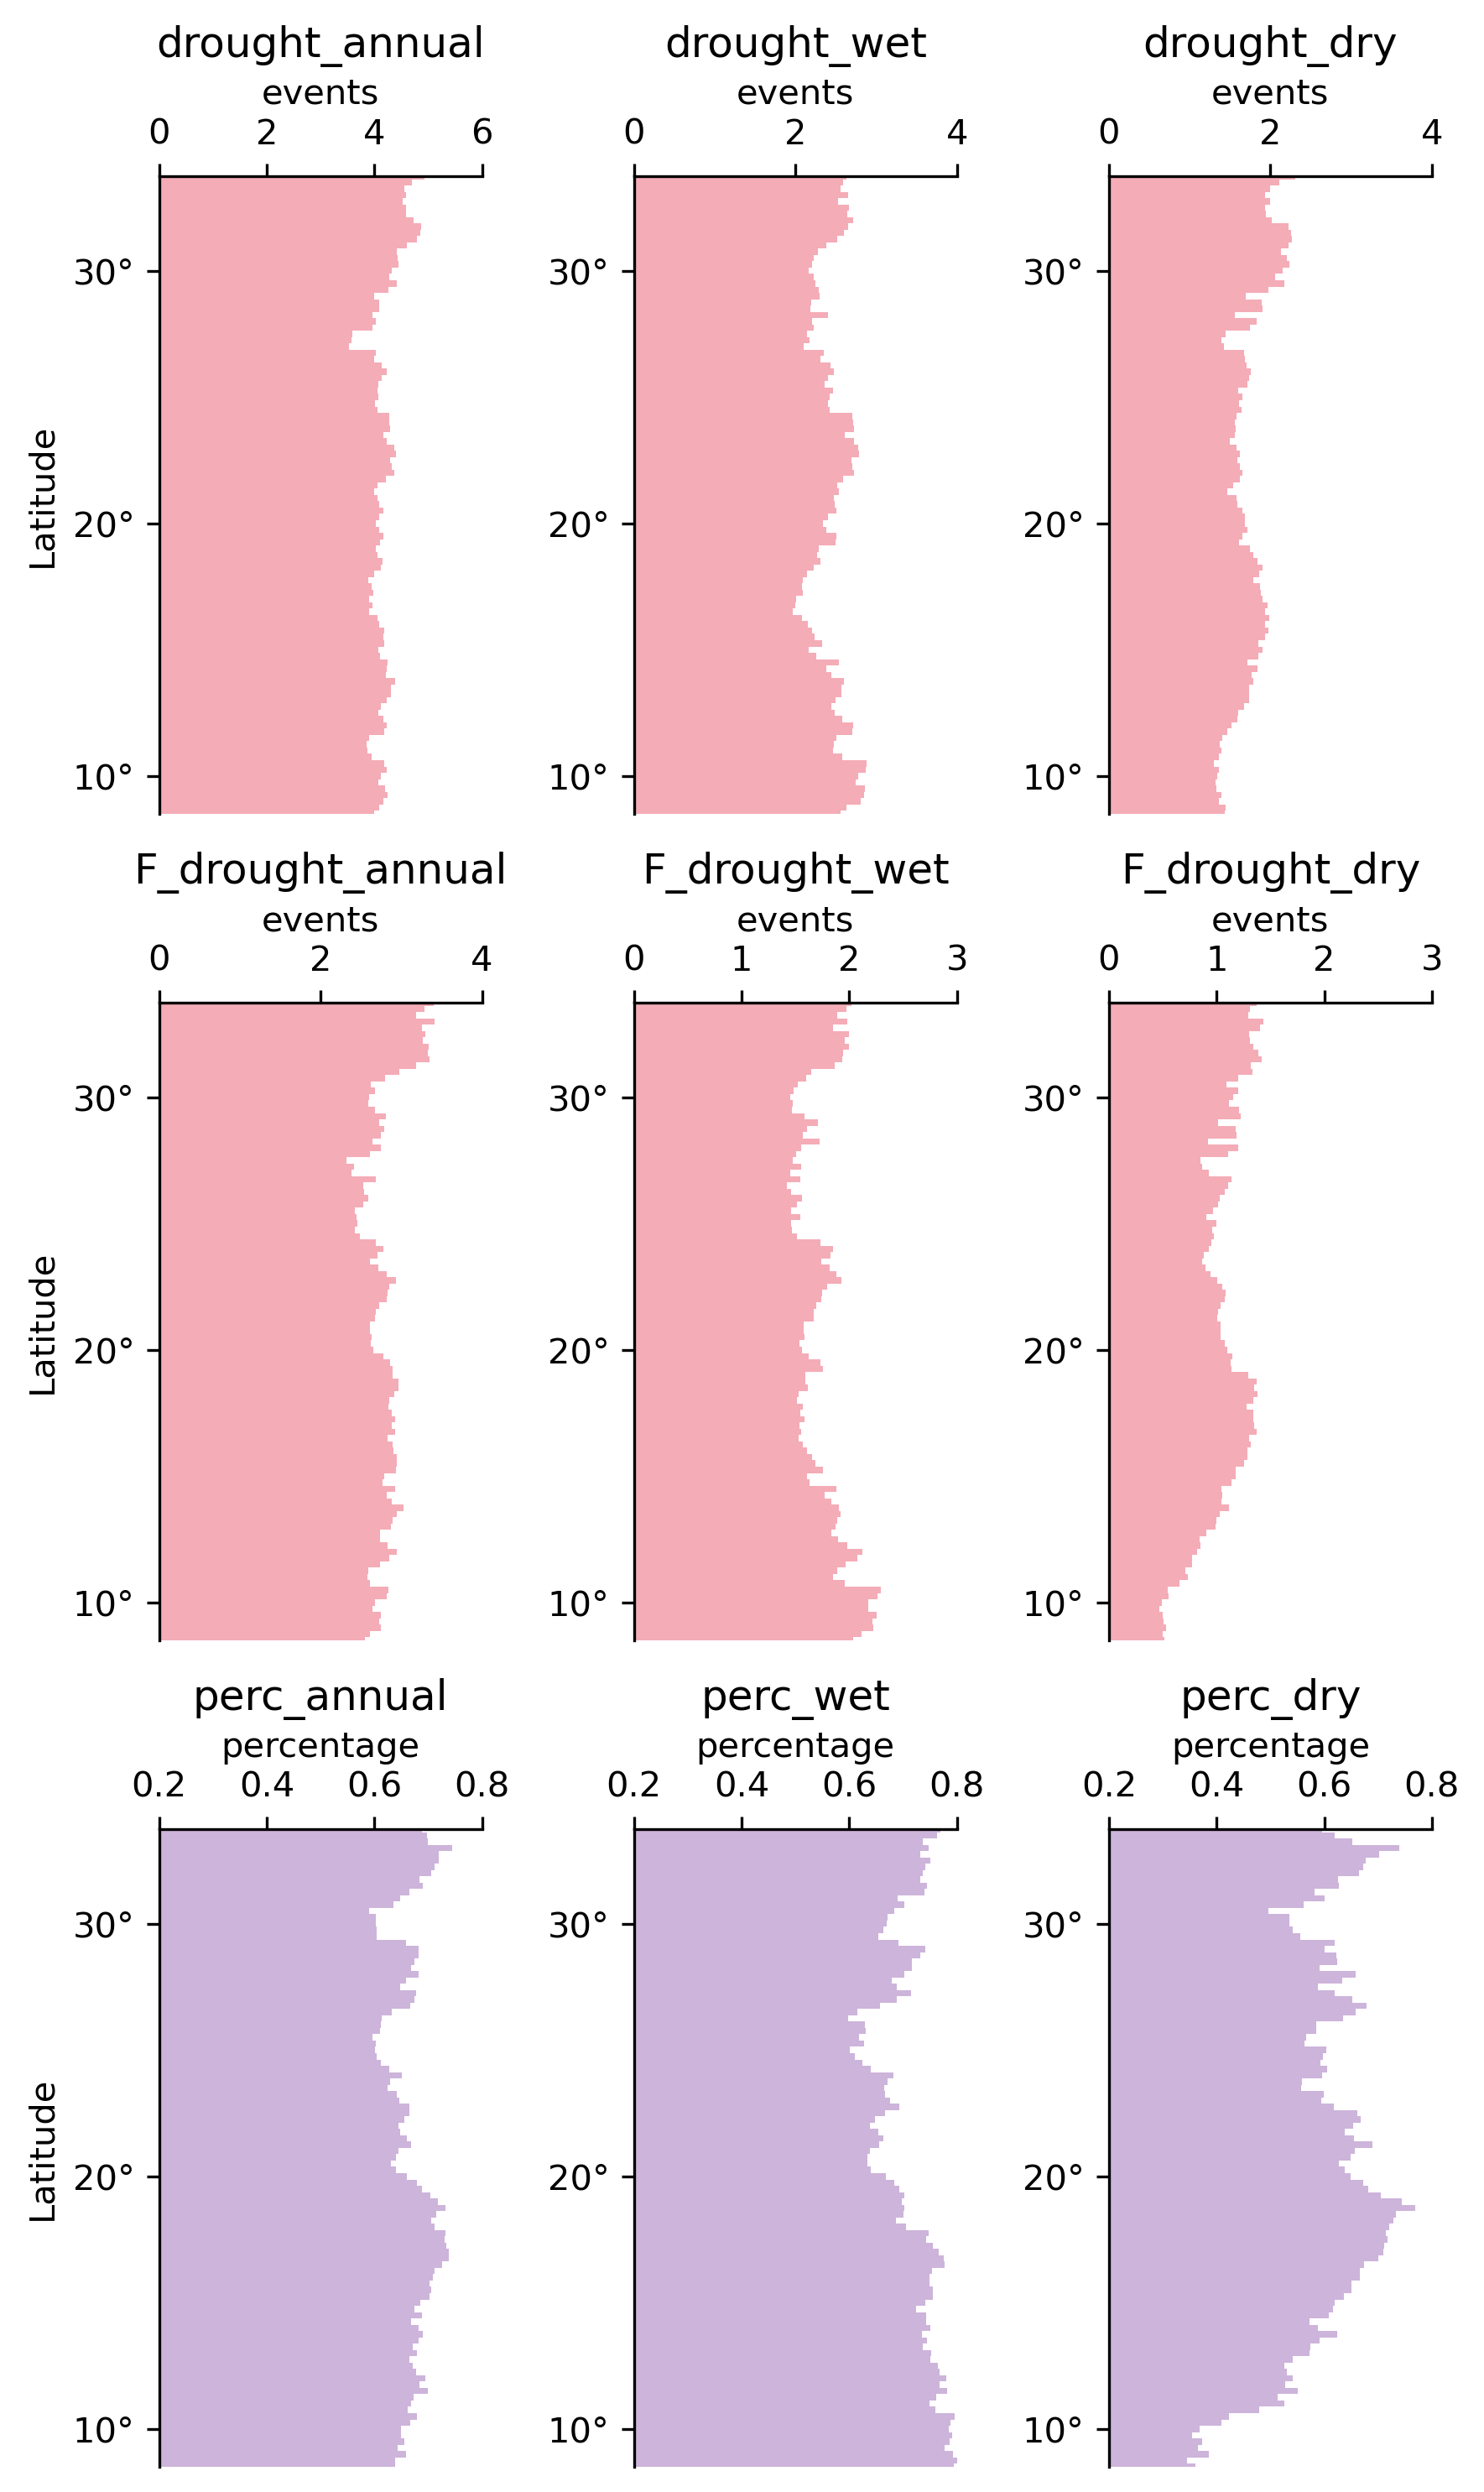

In [29]:

fig, axes = plt.subplots(3, 3, figsize=(6, 10), dpi=300)

bar_width = 1 # 设置柱状图宽度

for i, ax in enumerate(axes.flat):
    ax.barh(np.arange(0, 102), vari3[i][::-1], height=bar_width,color='#f4acb7',)  # 绘制第i个变量，设置宽度为bar_width
    title = ax.set_title(namess3[i])  # 设置子图标题
    ax.set_ylim([0, 101])
    ax.xaxis.tick_top()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_label_position('top')
    ax.set_yticks([6,46,86]) 
    ax.set_yticklabels(['10°', '20°', '30°'])
    if i == 0:
        ax.set_xlim(0, 6)  
        ax.set_ylabel('Latitude') 
        ax.set_xlabel('events')
    elif i == 1:
        ax.set_xlim(0, 4)  
        ax.set_xlabel('events')
    elif i == 2:
        ax.set_xlim(0, 4)
        ax.set_xlabel('events')
    elif i == 3:
        ax.set_xlim(0, 4)
        ax.set_ylabel('Latitude') 
        ax.set_xlabel('events')
    elif i == 4:
        ax.set_xlim(0, 3)
        ax.set_xlabel('events')
    elif i == 5:
        ax.set_xlim(0, 3)
        ax.set_xlabel('events')
    elif i == 6:
        ax.barh(np.arange(0, 102), vari3[i][::-1], height=bar_width,color='#cdb4db')
        ax.set_xlabel('percentage')
        ax.set_ylabel('Latitude') 
        ax.set_xlim(0.2, 0.8)
        ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    elif i == 7:
        ax.barh(np.arange(0, 102), vari3[i][::-1], height=bar_width,color='#cdb4db',)
        ax.set_xlim(0.2, 0.8)
        ax.set_xlabel('percentage',)
        ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    elif i == 8:
        ax.barh(np.arange(0, 102), vari3[i][::-1], height=bar_width,color='#cdb4db',)
        ax.set_xlim(0.2, 0.8)
        ax.set_xlabel('percentage')
        ax.set_xticks([0.2, 0.4, 0.6, 0.8])
plt.tight_layout()  # 调整子图布局
plt.show()




# kernel density map of drought events

In [30]:
vari4 = [total_d_box,wet_d_box,dry_d_box,total_fd_box,wet_fd_box,dry_fd_box]
clist3 =['#fffdf7','#99d6ea','#6798c0','#f0a7a0','#f26ca7','#a564f5']
cmap3 = LinearSegmentedColormap.from_list('chaos',clist3)

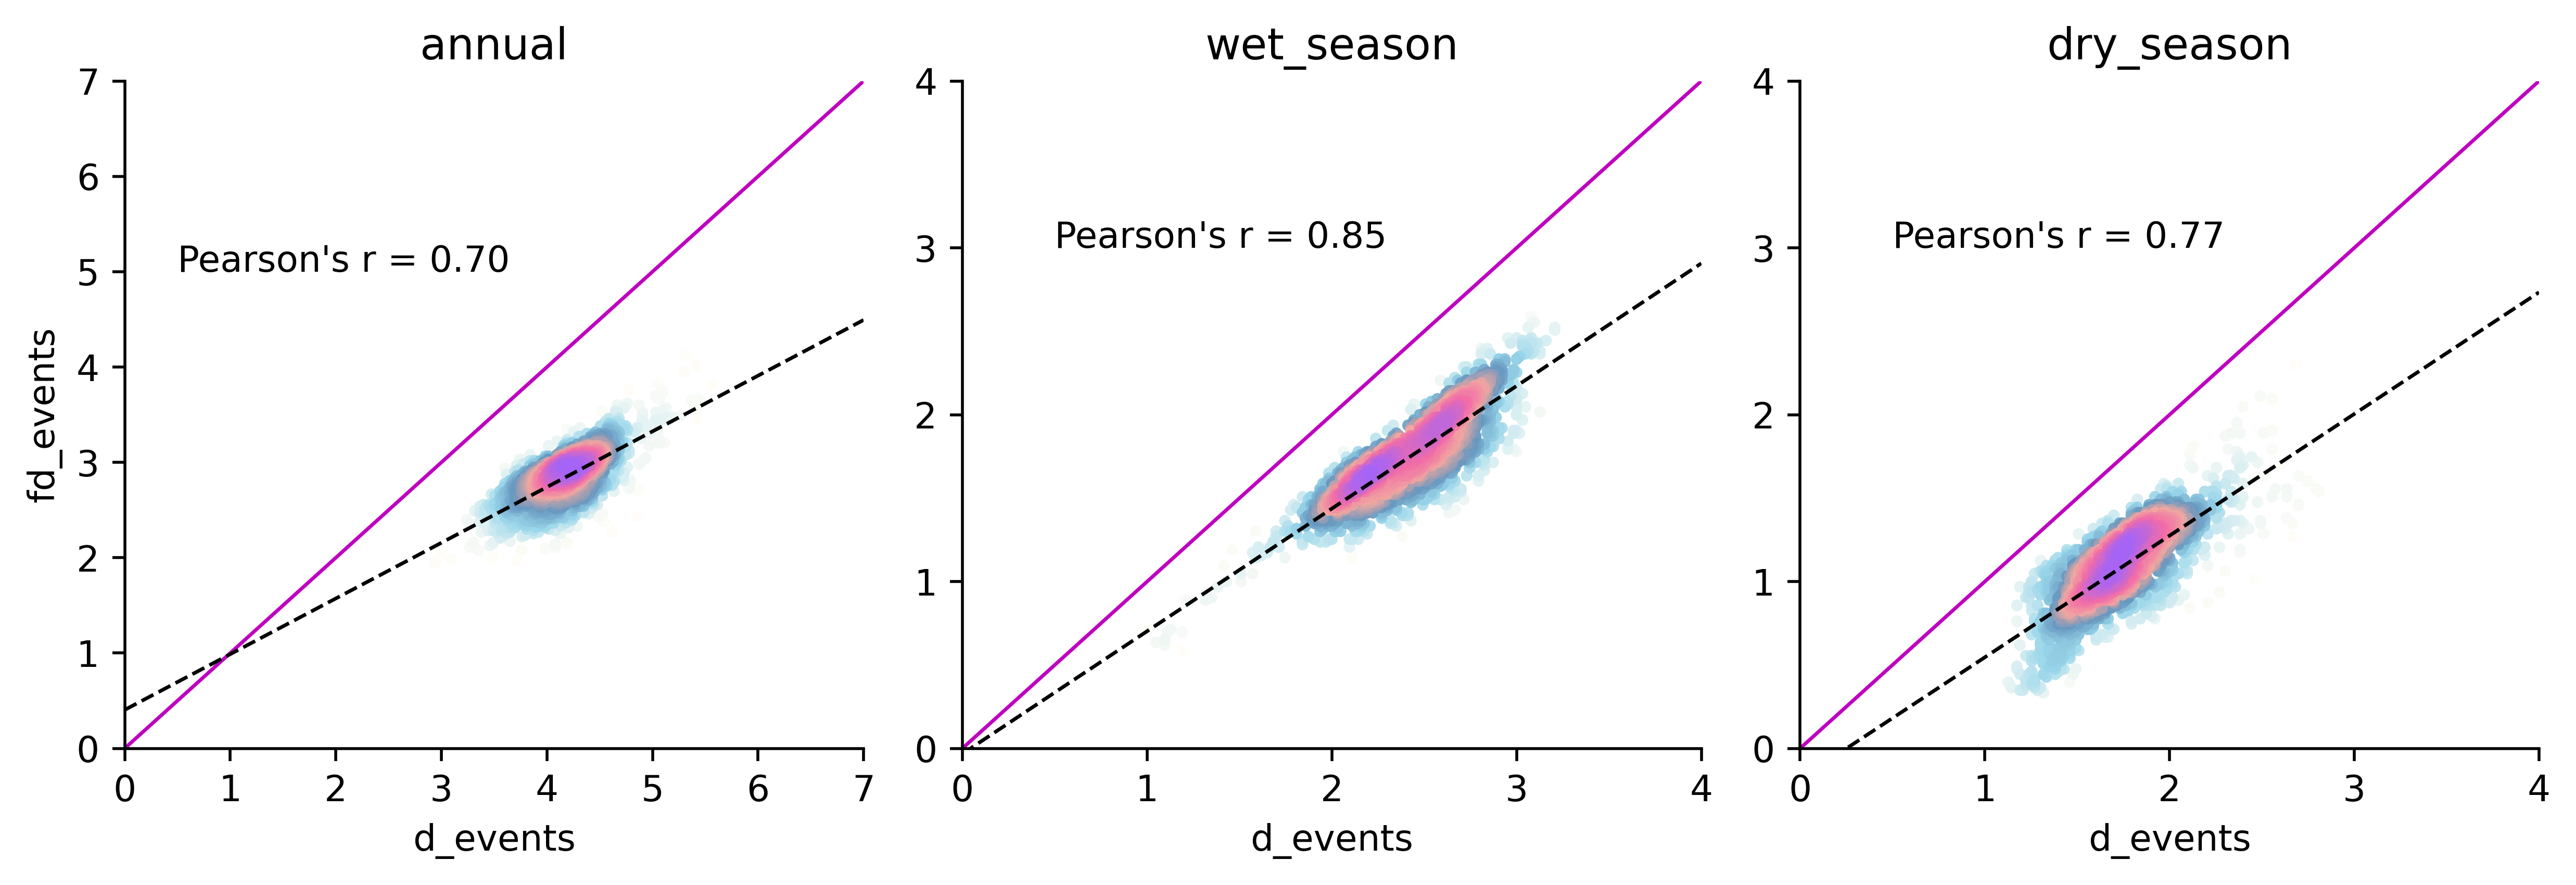

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), dpi=500)
axes[0].set_xlim(0, 7)
axes[0].set_ylim(0, 7)
axes[0].set_ylabel('fd_events')

# Set limits for the second plot
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)

# Set limits for the third plot
axes[2].set_xlim(0, 4)
axes[2].set_ylim(0, 4)

for i, (data1, data2) in enumerate(zip(vari4[0:3], vari4[3:6])):
    x = data1
    y = data2

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    r, p = pearsonr(x, y)
    # Plot the scatter plot
    ax = axes[i]
    ax.scatter(x, y, c=z, s=5, cmap=cmap3)
    ax.set_xlabel('d_events')
    ax.plot([0, ax.get_ylim()[1]], [0, ax.get_ylim()[1]], 'm-',lw=1)
    
    # ax.text(0.05, 4, f'p-value = {p:.2f}') # Add the p-value to the plot
    x_fit = np.linspace(axes[i].get_xlim()[0], axes[i].get_xlim()[1], num=100)
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    m = model.coef_[0]
    b = model.intercept_
    ax.plot(x_fit, m * x_fit + b, 'k--', label='Fitting Line',lw=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i == 1:
        ax.set_yticks([0, 1, 2, 3, 4])
        ax.text(0.5,3,f'Pearson\'s r = {r:.2f}')
        ax.set_title('wet_season')
    if i == 2:
        ax.set_yticks([0, 1, 2, 3, 4])
        ax.text(0.5,3,f'Pearson\'s r = {r:.2f}')
        ax.set_title('dry_season')
    if i == 0:
        ax.set_xticks([0, 1, 2, 3, 4,5,6,7])
        ax.text(0.5,5,f'Pearson\'s r = {r:.2f}')
        ax.set_title('annual')
# Add colorbar to the last plot
# fig.colorbar(ax.collections[0], ax=axes)

plt.tight_layout()
plt.show()


In [32]:
names = locals()
namess5 =['d_1960-1980','d_1981-2001','d_2002-2022','fd_1960-1980','fd_1981-2001','fd_2002-2022',]

total_fd_1 = np.nanmean(count_totalfd[0:21],axis=0)
total_fd_2 = np.nanmean(count_totalfd[21:42],axis=0)
total_fd_3 = np.nanmean(count_totalfd[42:63],axis=0)

total_d_1 = np.nanmean(count_totald[0:21],axis=0)
total_d_2 = np.nanmean(count_totald[21:42],axis=0)
total_d_3 = np.nanmean(count_totald[42:63],axis=0)


clist4 =['#fffdf7','#99d6ea','#6798c0','#f0a7a0','#f26ca7','#a019a6']
cmap4 = LinearSegmentedColormap.from_list('chaos',clist4)


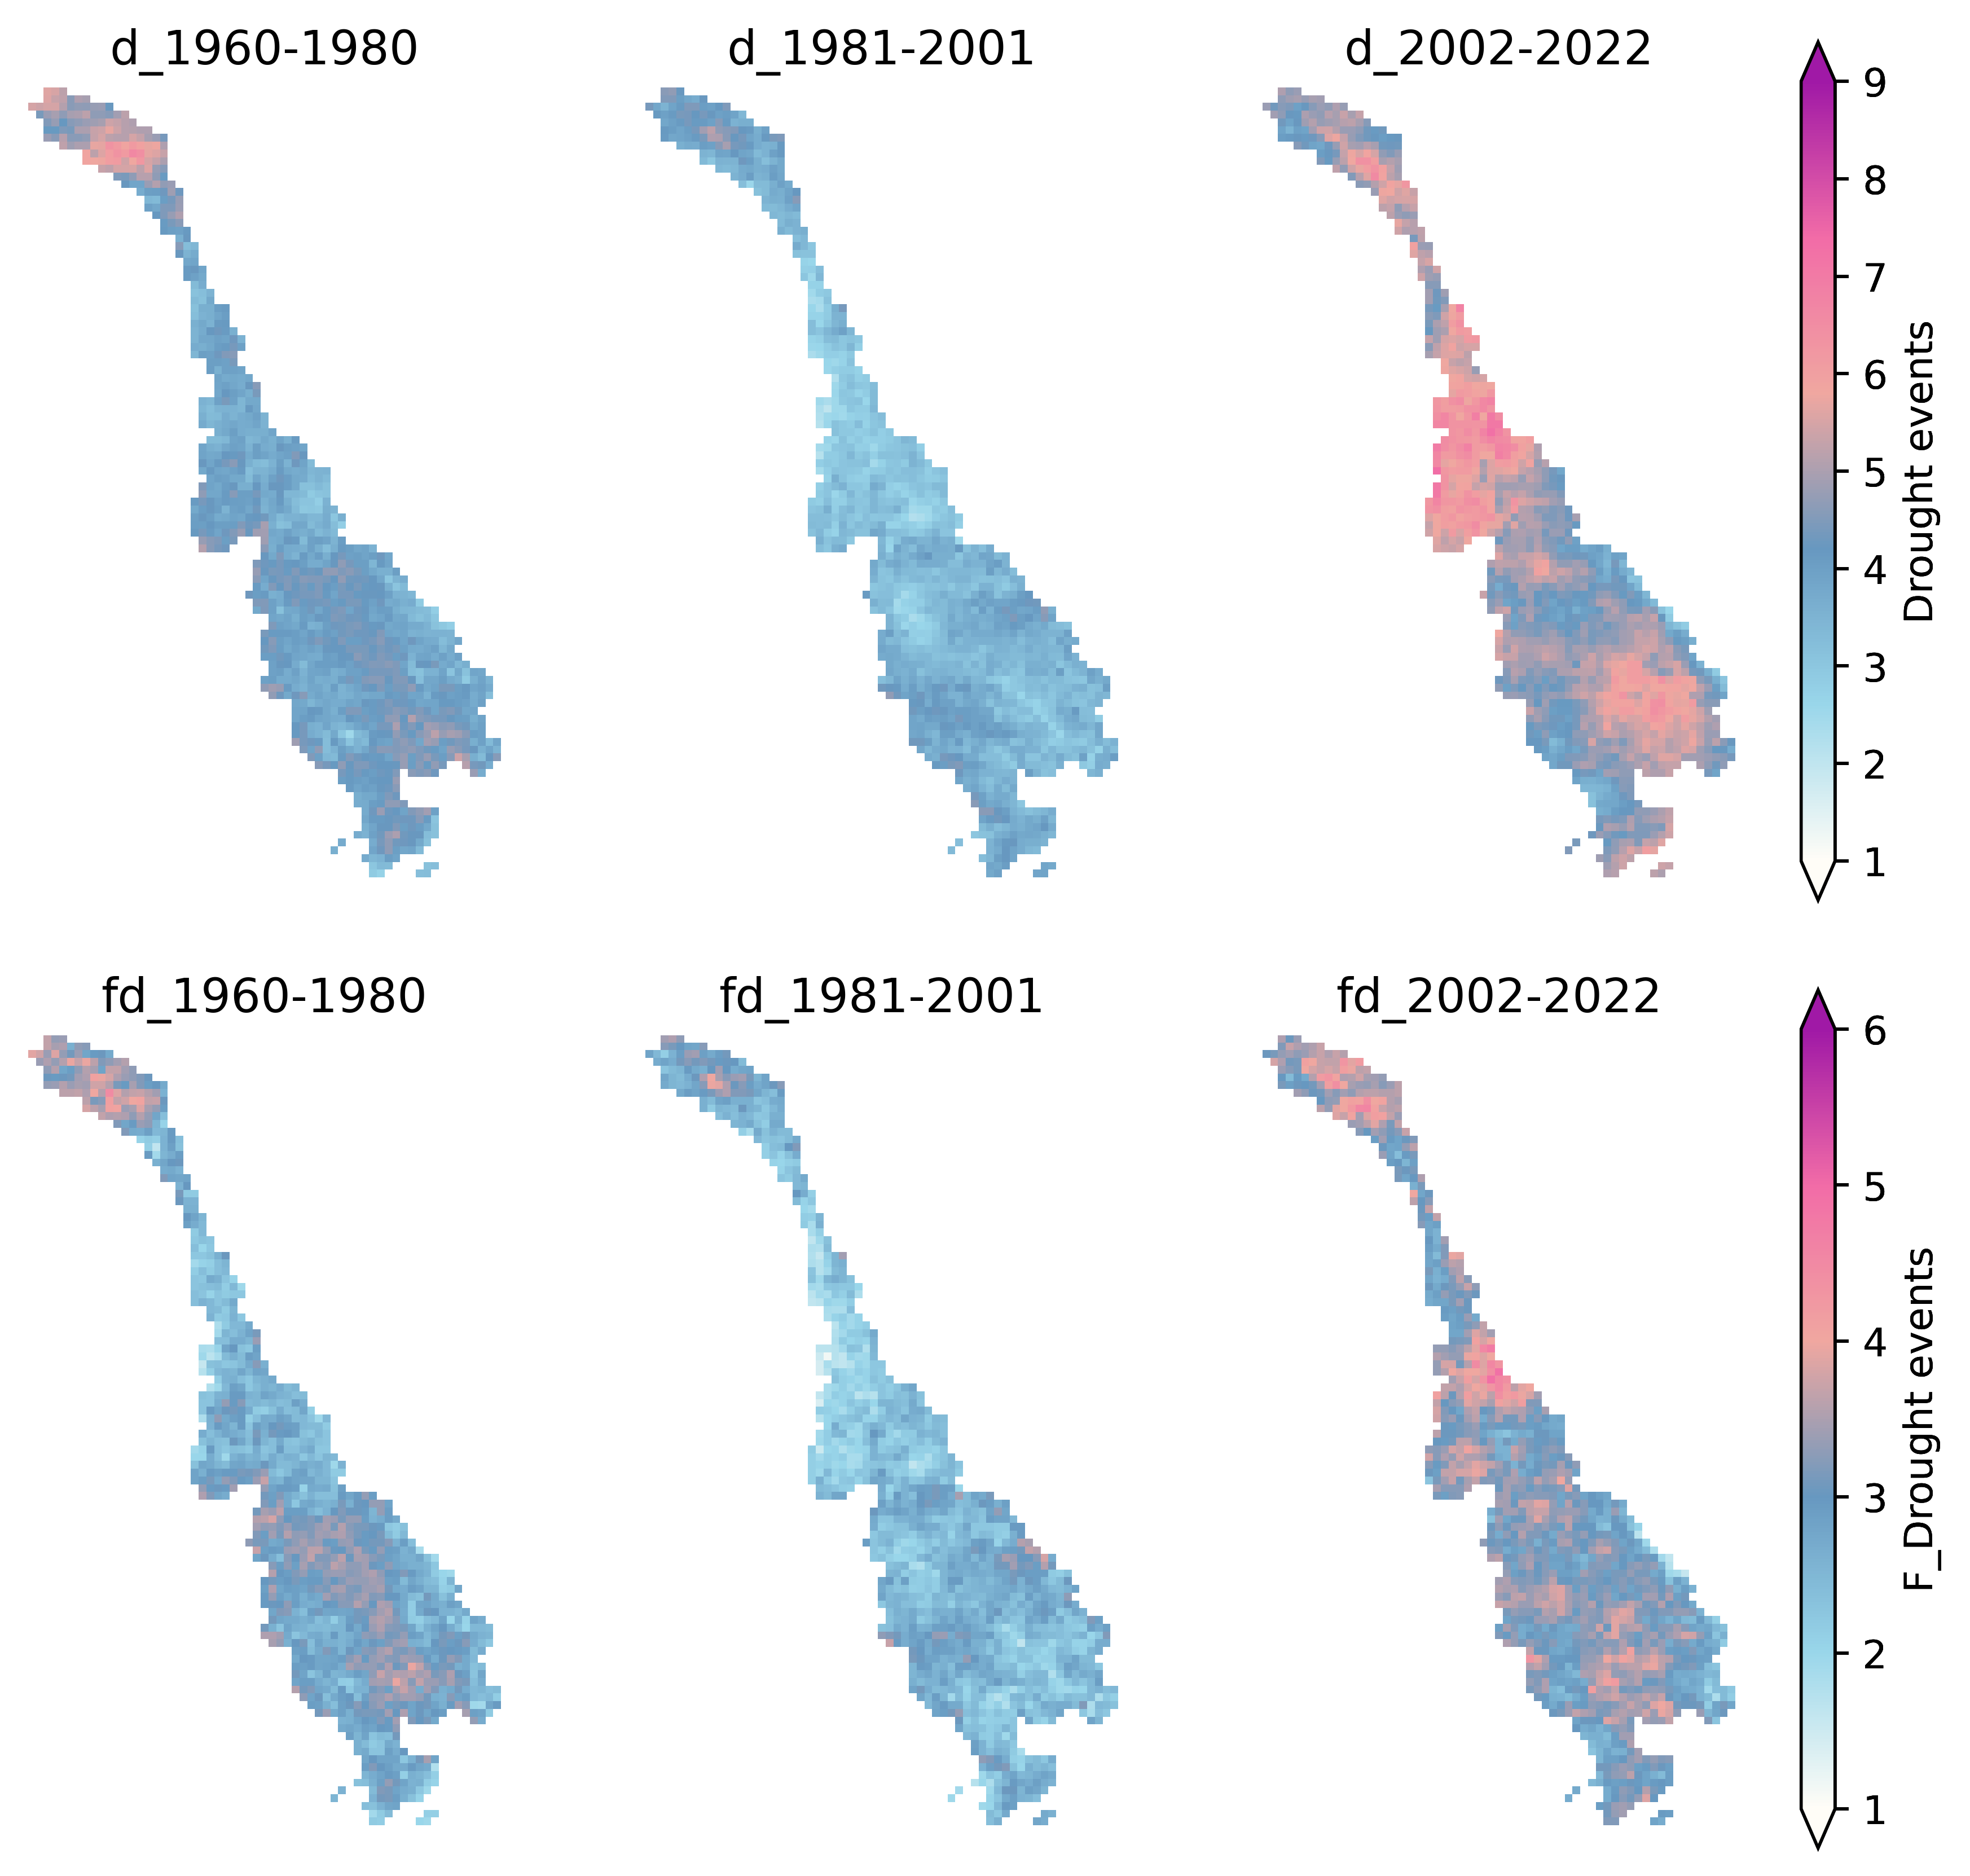

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(8 , 8), dpi=500)
images = []

varia5 = [total_d_1,total_d_2,total_d_3,total_fd_1,total_fd_2,total_fd_3]

for i, (qt, subplot, name) in enumerate(zip(varia5, ax.flat, namess5)):
    im = subplot.imshow(qt, cmap=cmap4, interpolation='nearest')
    images.append(im)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_frame_on(False)
    ax[-1, -1].axis('off')
    subplot.set_title(name)
    if i == 0 or i == 1 or i == 2:
        cax = fig.add_axes([0.92, 0.52, 0.015, 0.38])  
        cbar = plt.colorbar(im, cax=cax, extend='both')
        cbar.set_label('Drought events')
        im.set_clim(vmin=1, vmax=9)
    if i == 3 or i == 4 or i == 5:
        cax = fig.add_axes([0.92, 0.1, 0.015, 0.38]) 
        cbar = plt.colorbar(im, cax=cax, extend='both')
        cbar.set_label('F_Drought events')
        im.set_clim(vmin=1, vmax=6)

# Drought event trend spatial distribution

In [34]:
clist6=['#035a96','#1079c3','#3d9fee','#ffffff','#ff6d6d','#f26ca7','#920efc']
cmap6 = LinearSegmentedColormap.from_list('chaos',clist6)

In [35]:
namess6 =['d_a','d_wet','d_dry','fd_a','fd_wet','fd_dry','perc_a','perc_wet','perc_dry'] #a means after 1980
VVVV = [count_totald,count_wetd,count_dryd,count_totalfd,count_wetfd,count_dryfd,
        count_totalfd/count_totald,count_wetfd/count_wetd,count_dryfd/count_dryd]
clist5=['#3d9fee','#ffffff','#ff6d6d','#f26ca7','#920efc']
cmap5 = LinearSegmentedColormap.from_list('chaos',clist5)

### 1960-2022

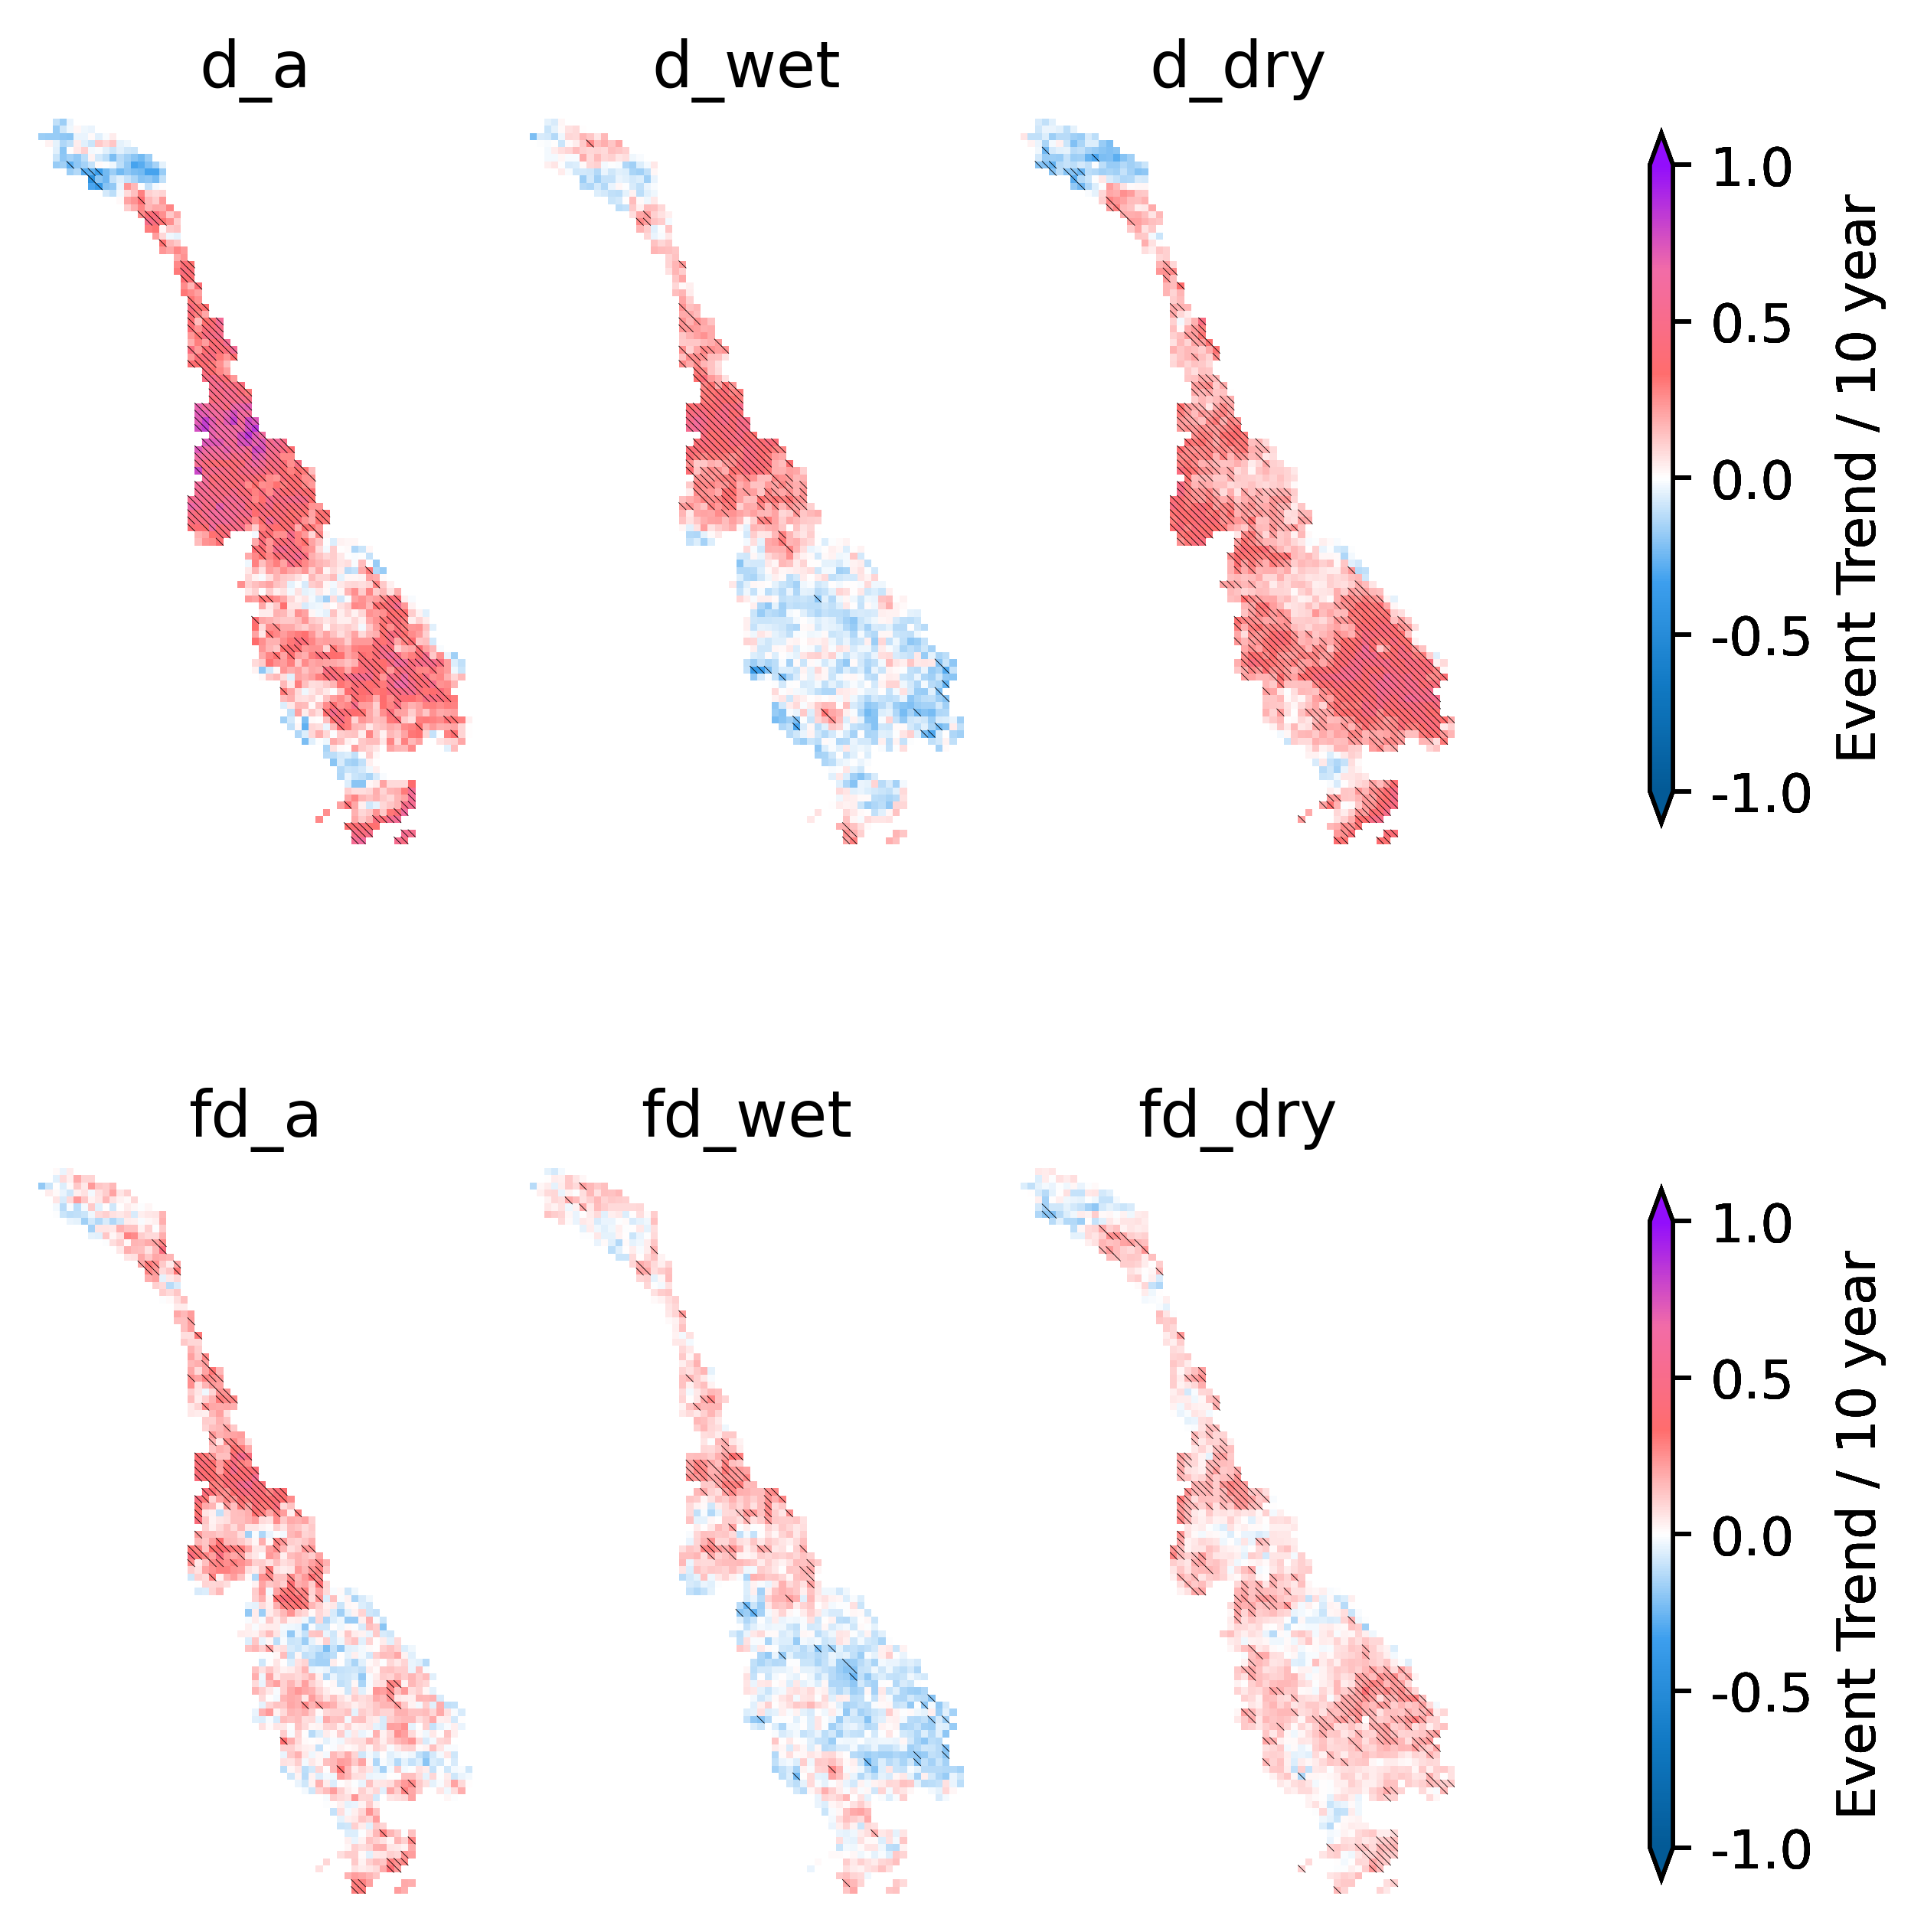

In [36]:
for k in range(0,9):
    names[namess6[k]+'_p'], names[namess6[k]+'_co']= [],[]
    for i in range(0,102):
        for j in range(0,61):
            array = VVVV[k][:, i, j]
            if np.isnan(array).all():
                names[namess6[k]+'_co'].append(np.nan)
                names[namess6[k]+'_p'].append(np.nan)
            
            else :
                x = np.arange(VVVV[k][:, i, j].shape[0])
                valid_indices = np.where(~np.isnan(array))
                valid_x = x[valid_indices]
                valid_array = array[valid_indices]
                
                slope, intercept, r_value, p_value, std_err = linregress(valid_x, valid_array)
                names[namess6[k]+'_co'].append(slope)

                if p_value < 0.05:
                    names[namess6[k]+'_p'].append(1)
                else:
                    names[namess6[k]+'_p'].append(np.nan)
                
    names[namess6[k]+'_p'] = np.array(names[namess6[k]+'_p']).reshape(102,61)
    names[namess6[k]+'_co'] = np.array(names[namess6[k]+'_co']).reshape(102,61)
    
    #####################################################################
    
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(4, 6), dpi=500)
images = []

varia6c = [d_a_co, d_wet_co, d_dry_co, fd_a_co, fd_wet_co, fd_dry_co, perc_a_co, perc_wet_co,perc_dry_co,]
varia6p = [d_a_p, d_wet_p, d_dry_p, fd_a_p, fd_wet_p, fd_dry_p, perc_a_p, perc_wet_p,perc_dry_p,]

for i, (qt, ij, subplot, name) in enumerate(zip(varia6c, varia6p, ax.flat, namess6)):
    if i == 0 or 1 or 2 or 3 or 4 or 5:
        im = subplot.imshow(qt*10, cmap=cmap6, interpolation='nearest',vmin=-1,vmax=1)
        images.append(im)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.set_frame_on(False)
        ax[-1, -1].axis('off')
        subplot.set_title(name)

        cax1 = fig.add_axes([1.09, 0.12, 0.015, 0.3]) 
        cbar1 = plt.colorbar(im, cax=cax1, extend='both')
        cbar1.set_label('Event Trend / 10 year')
        im.set_clim(vmin=-1, vmax=1)
        cbar1.set_ticks([-1,-0.5, 0, 0.5, 1,])
        cbar1.set_ticklabels(['-1.0','-0.5', '0.0', '0.5', '1.0',])
        cax2 = fig.add_axes([1.09, 0.58, 0.015, 0.3]) 
        cbar2 = plt.colorbar(im, cax=cax2, extend='both')
        cbar2.set_label('Event Trend / 10 year')
        im.set_clim(vmin=-1, vmax=1)
        cbar2.set_ticks([-1,-0.5, 0, 0.5, 1,])
        cbar2.set_ticklabels(['-1.0','-0.5', '0.0', '0.5', '1.0',])

    # 显示显著性的对角线网格
    for y in range(ij.shape[0]):
        for x in range(ij.shape[1]):
            if ij[y, x] == 1:
                subplot.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='k',lw=0.12)

    
plt.tight_layout()
plt.show()

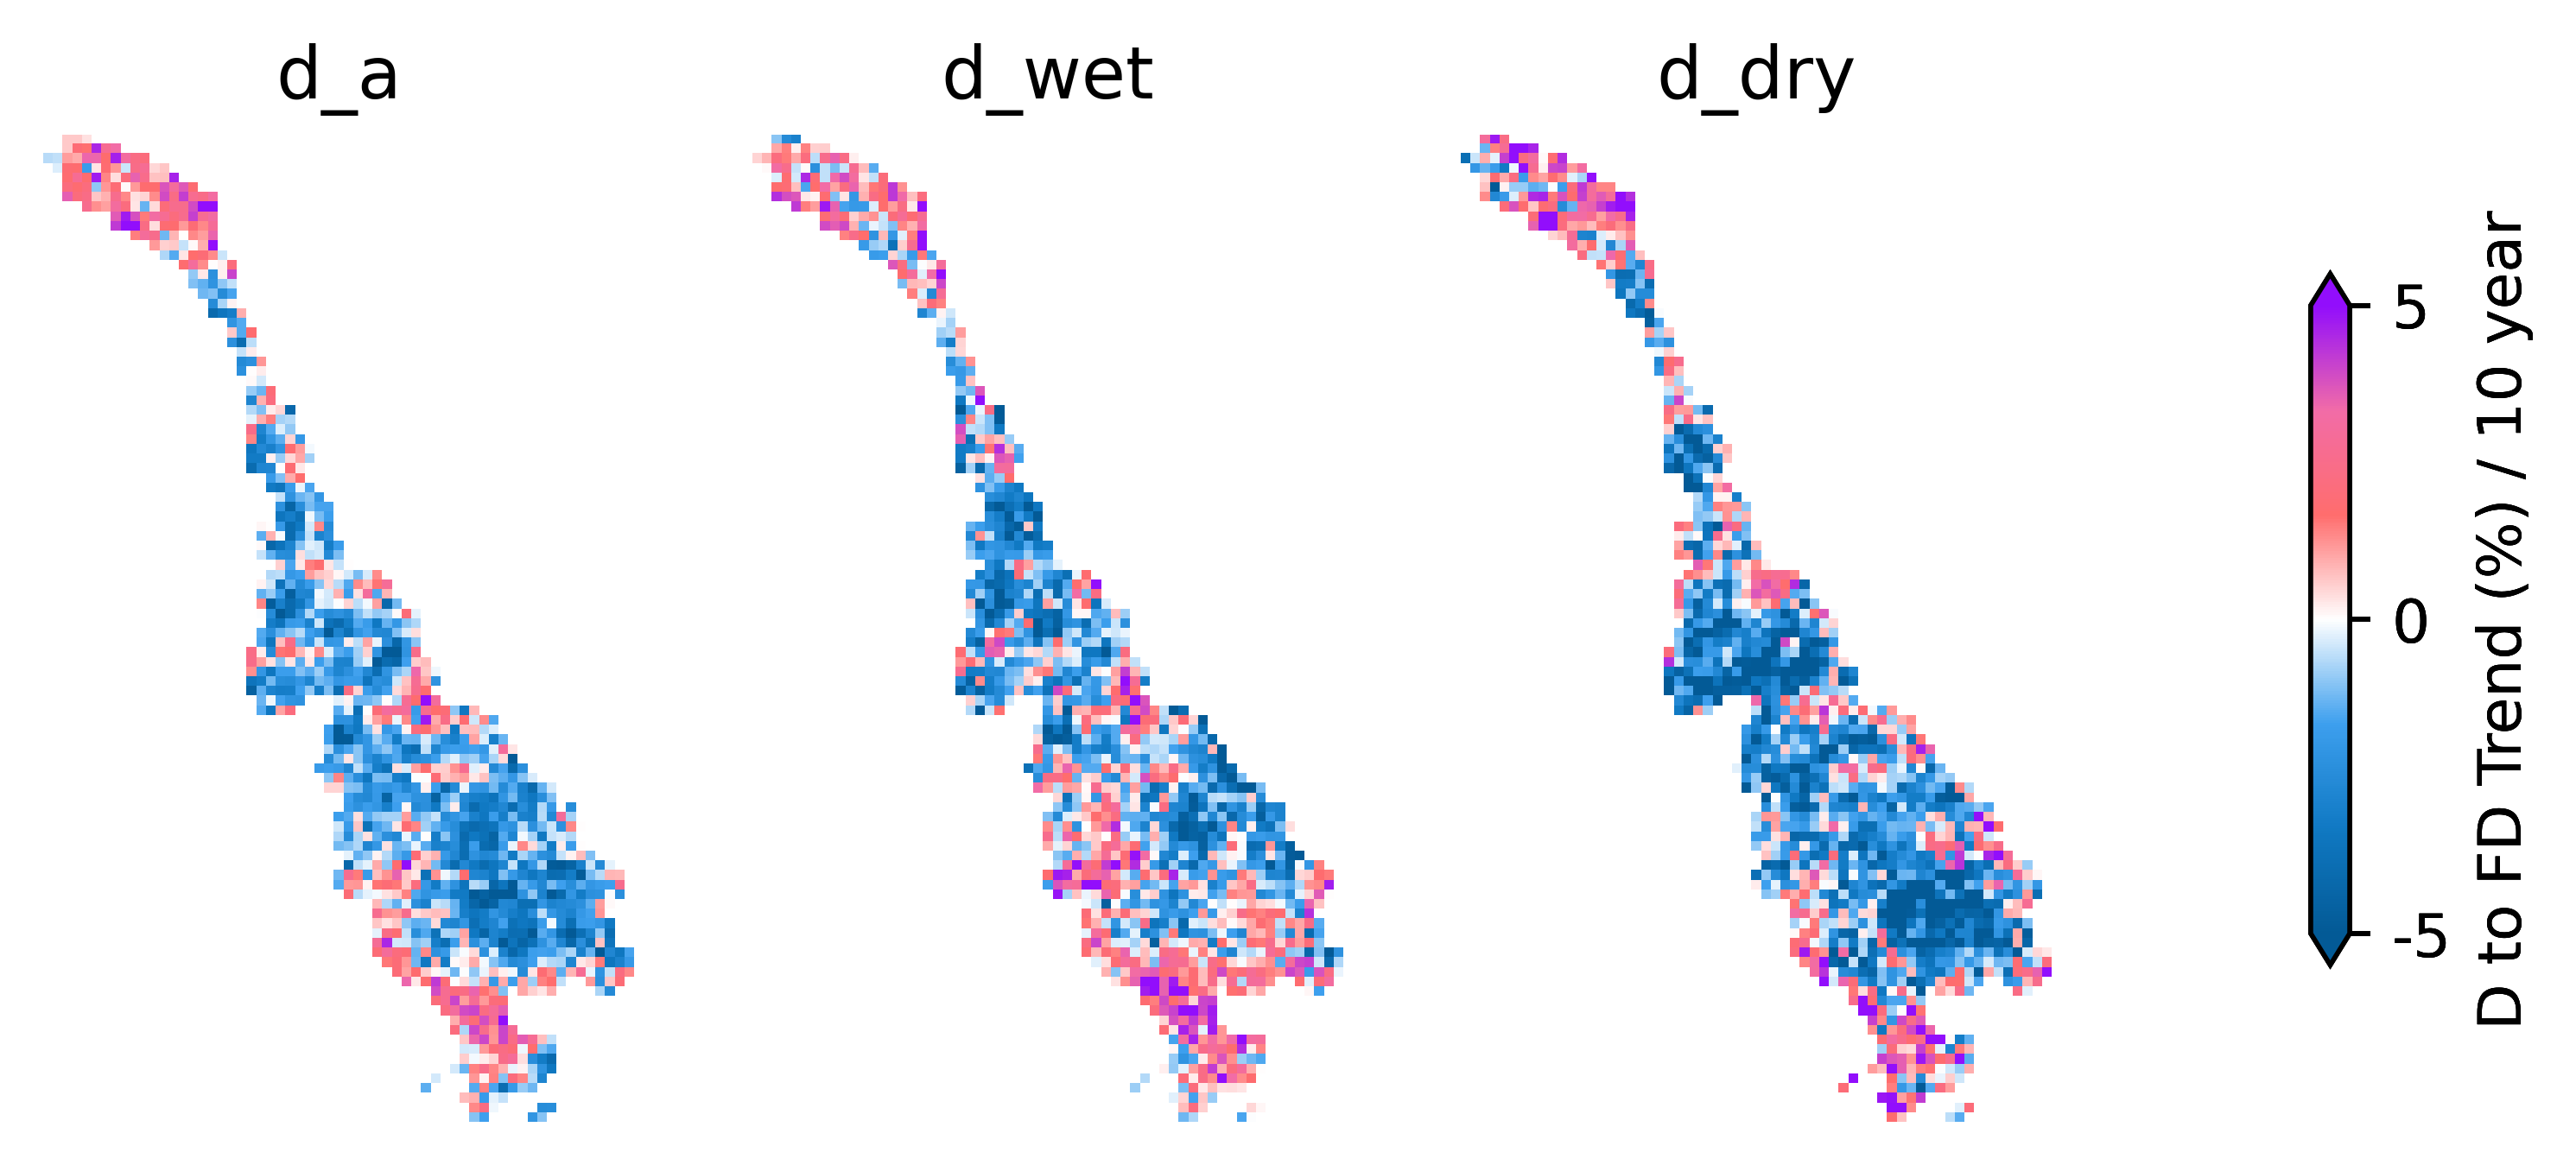

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(6, 4), dpi=500)
images = []

varia6c = [perc_a_co, perc_wet_co,perc_dry_co,]
varia6p = [perc_a_p, perc_wet_p,perc_dry_p,]

for i, (qt, ij, subplot, name) in enumerate(zip(varia6c, varia6p, ax.flat, namess6)):
    im = subplot.imshow(qt*1000, cmap=cmap6, interpolation='nearest',vmin=-5,vmax=5)
    images.append(im)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_frame_on(False)
    #ax[-1, -1].axis('off')
    subplot.set_title(name)
    cax1 = fig.add_axes([1.0, 0.3, 0.015, 0.4]) 
    cbar1 = plt.colorbar(im, cax=cax1, extend='both')
    cbar1.set_label('D to FD Trend (%) / 10 year')
    cbar1.set_ticks([-5, 0, 5,])
    cbar1.set_ticklabels(['-5','0', '5',])

In [38]:
len(varia6c)

3

### 1981-2022

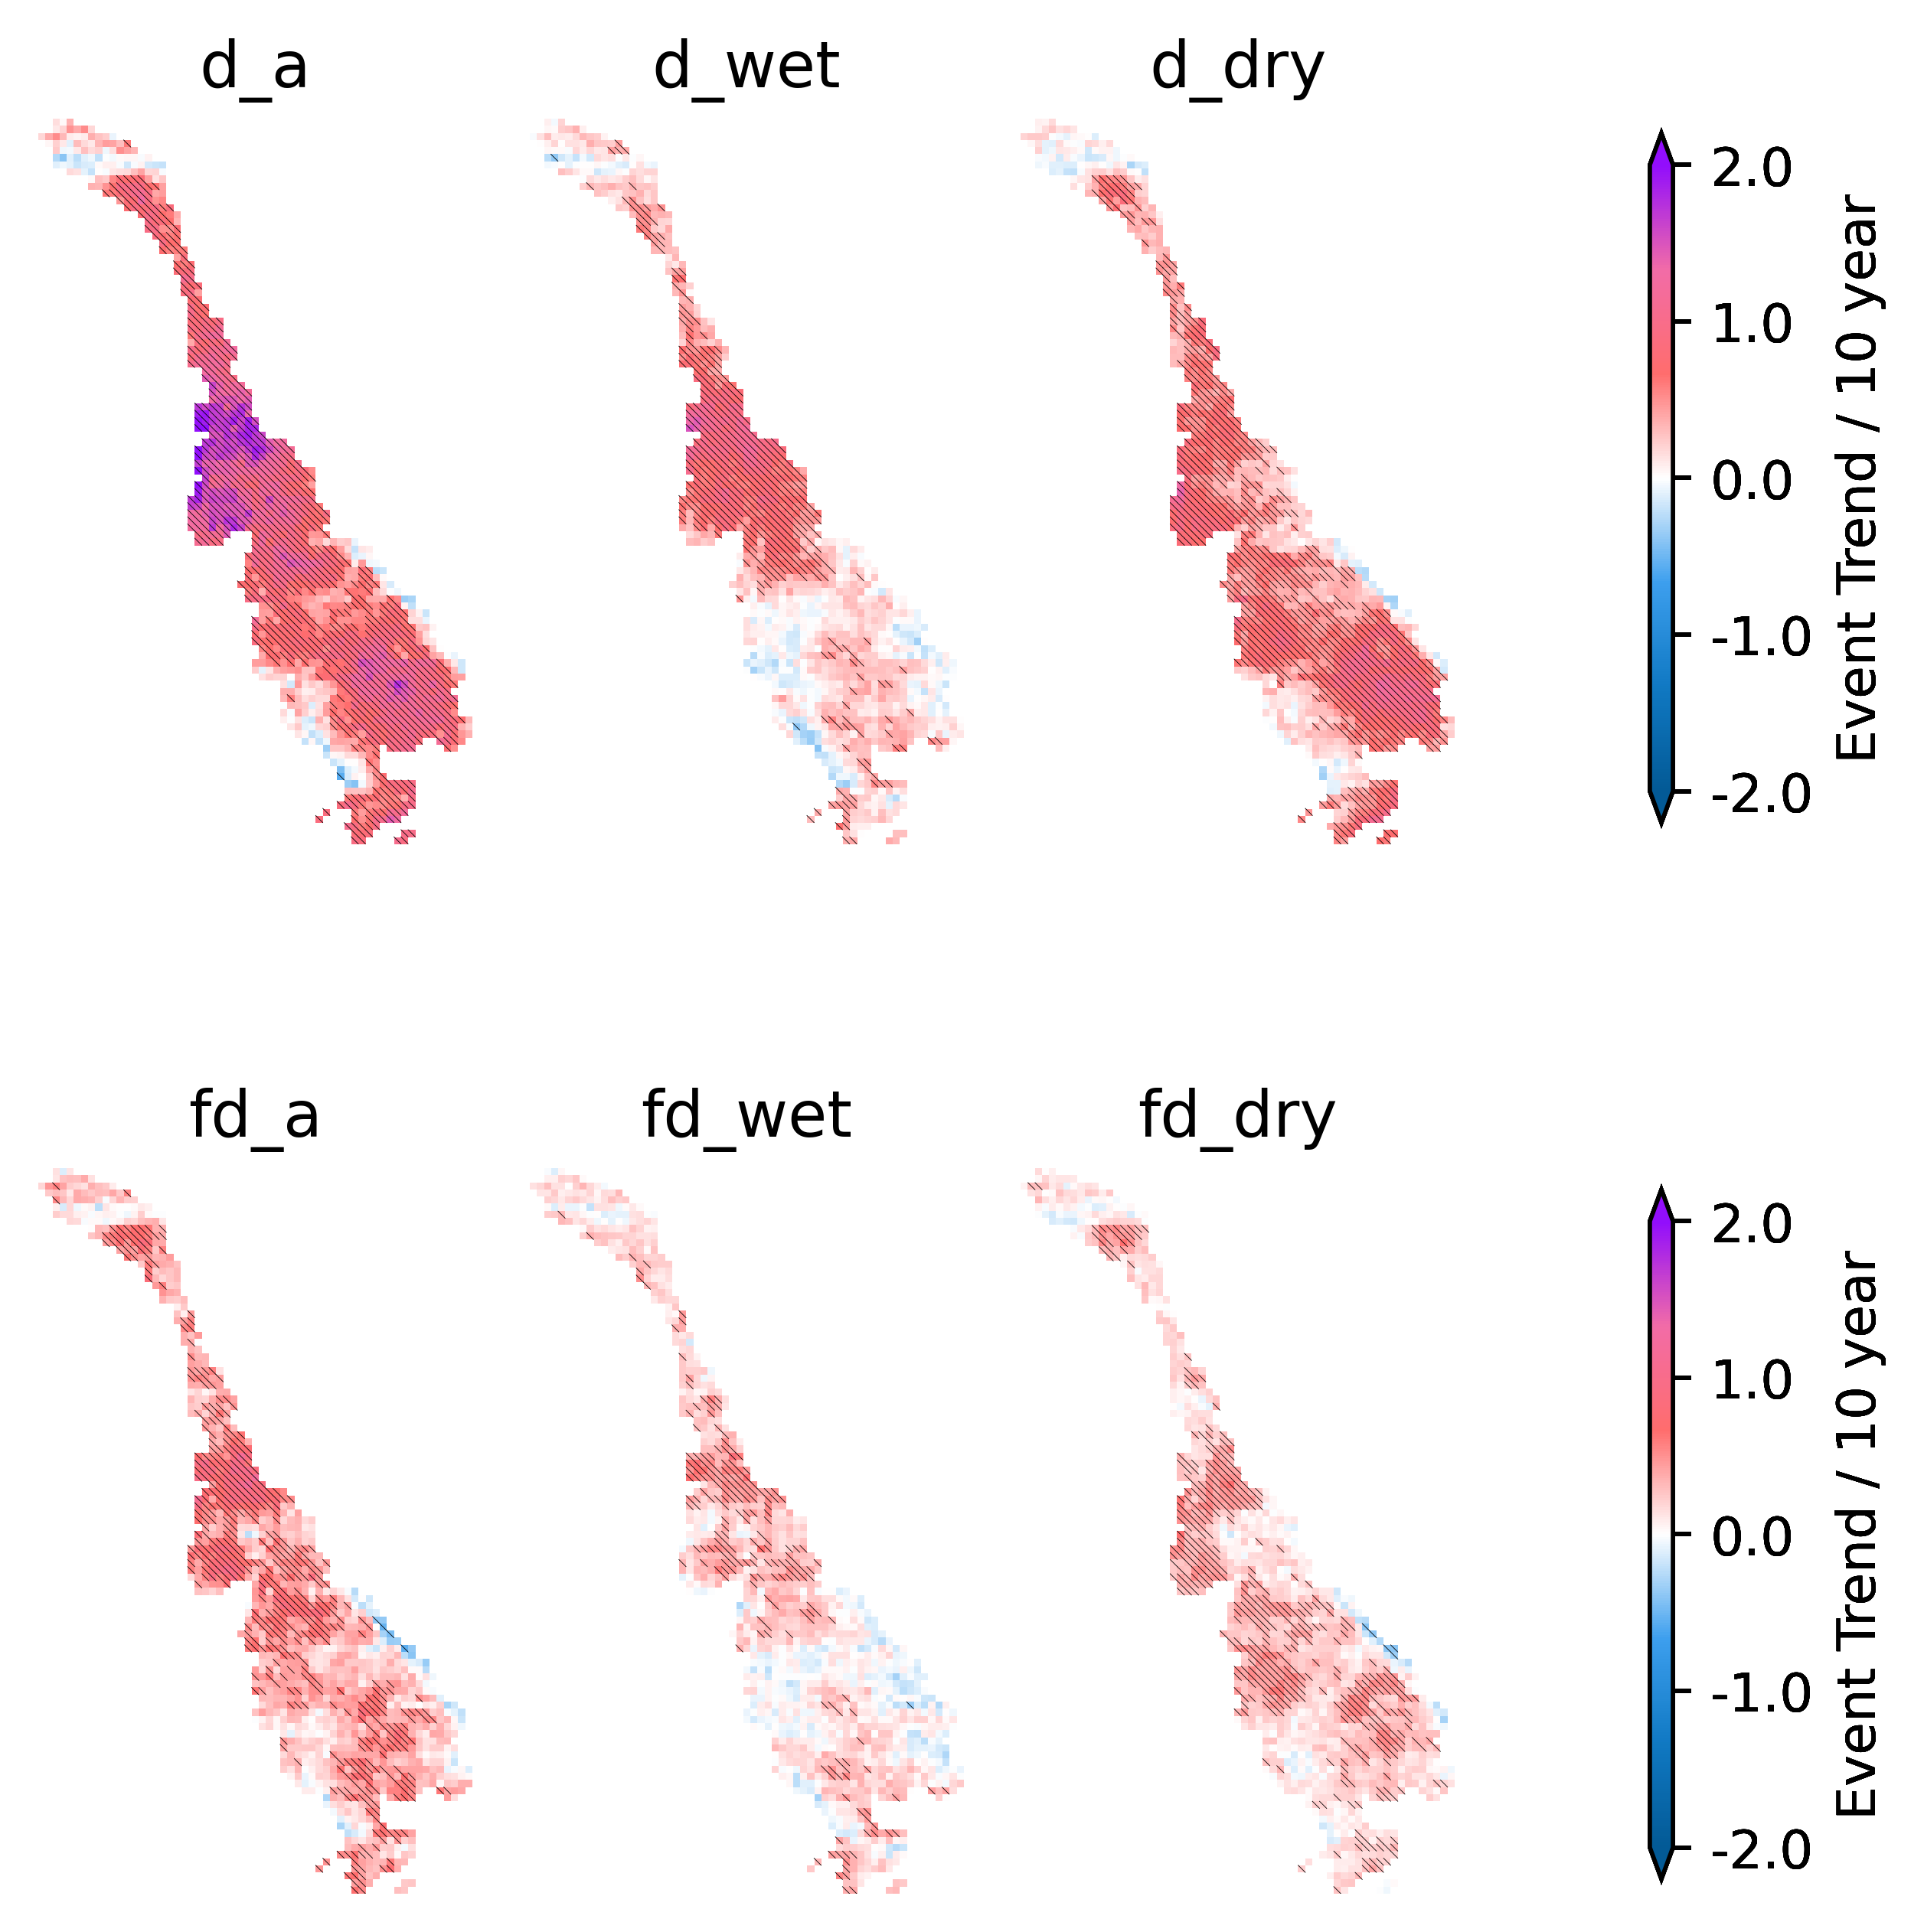

In [39]:
for k in range(0,9):
    names[namess6[k]+'_p'], names[namess6[k]+'_co']= [],[]
    for i in range(0,102):
        for j in range(0,61):
            array = VVVV[k][21:63, i, j]
            if np.isnan(array).all():
                names[namess6[k]+'_co'].append(np.nan)
                names[namess6[k]+'_p'].append(np.nan)
            
            else :
                x = np.arange(VVVV[k][21:63, i, j].shape[0])
                valid_indices = np.where(~np.isnan(array))
                valid_x = x[valid_indices]
                valid_array = array[valid_indices]
                
                slope, intercept, r_value, p_value, std_err = linregress(valid_x, valid_array)
                names[namess6[k]+'_co'].append(slope)

                if p_value < 0.05:
                    names[namess6[k]+'_p'].append(1)
                else:
                    names[namess6[k]+'_p'].append(np.nan)
                
    names[namess6[k]+'_p'] = np.array(names[namess6[k]+'_p']).reshape(102,61)
    names[namess6[k]+'_co'] = np.array(names[namess6[k]+'_co']).reshape(102,61)
    
    #####################################################################
    
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(4, 6), dpi=500)
images = []

varia6c = [d_a_co, d_wet_co, d_dry_co, fd_a_co, fd_wet_co, fd_dry_co]
varia6p = [d_a_p, d_wet_p, d_dry_p, fd_a_p, fd_wet_p, fd_dry_p]

for i, (qt, ij, subplot, name) in enumerate(zip(varia6c, varia6p, ax.flat, namess6)):
    im = subplot.imshow(qt*10, cmap=cmap6, interpolation='nearest')
    images.append(im)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_frame_on(False)
    ax[-1, -1].axis('off')
    subplot.set_title(name)

    # 显示显著性的对角线网格
    for y in range(ij.shape[0]):
        for x in range(ij.shape[1]):
            if ij[y, x] == 1:
                subplot.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='k',lw=0.12)
    cax1 = fig.add_axes([1.09, 0.12, 0.015, 0.3]) 
    cbar1 = plt.colorbar(im, cax=cax1, extend='both')
    cbar1.set_label('Event Trend / 10 year')
    im.set_clim(vmin=-2, vmax=2)
    cbar1.set_ticks([-2.0,-1.0, 0.0, 1.0, 2.0,])
    cbar1.set_ticklabels(['-2.0','-1.0', '0.0','1.0', '2.0',])
    cax2 = fig.add_axes([1.09, 0.58, 0.015, 0.3]) 
    cbar2 = plt.colorbar(im, cax=cax2, extend='both')
    cbar2.set_label('Event Trend / 10 year')
    im.set_clim(vmin=-2, vmax=2)
    cbar2.set_ticks([-2.0,-1.0, 0.0, 1.0, 2.0,])
    cbar2.set_ticklabels(['-2.0','-1.0', '0.0','1.0', '2.0',])
    
plt.tight_layout()
plt.show()

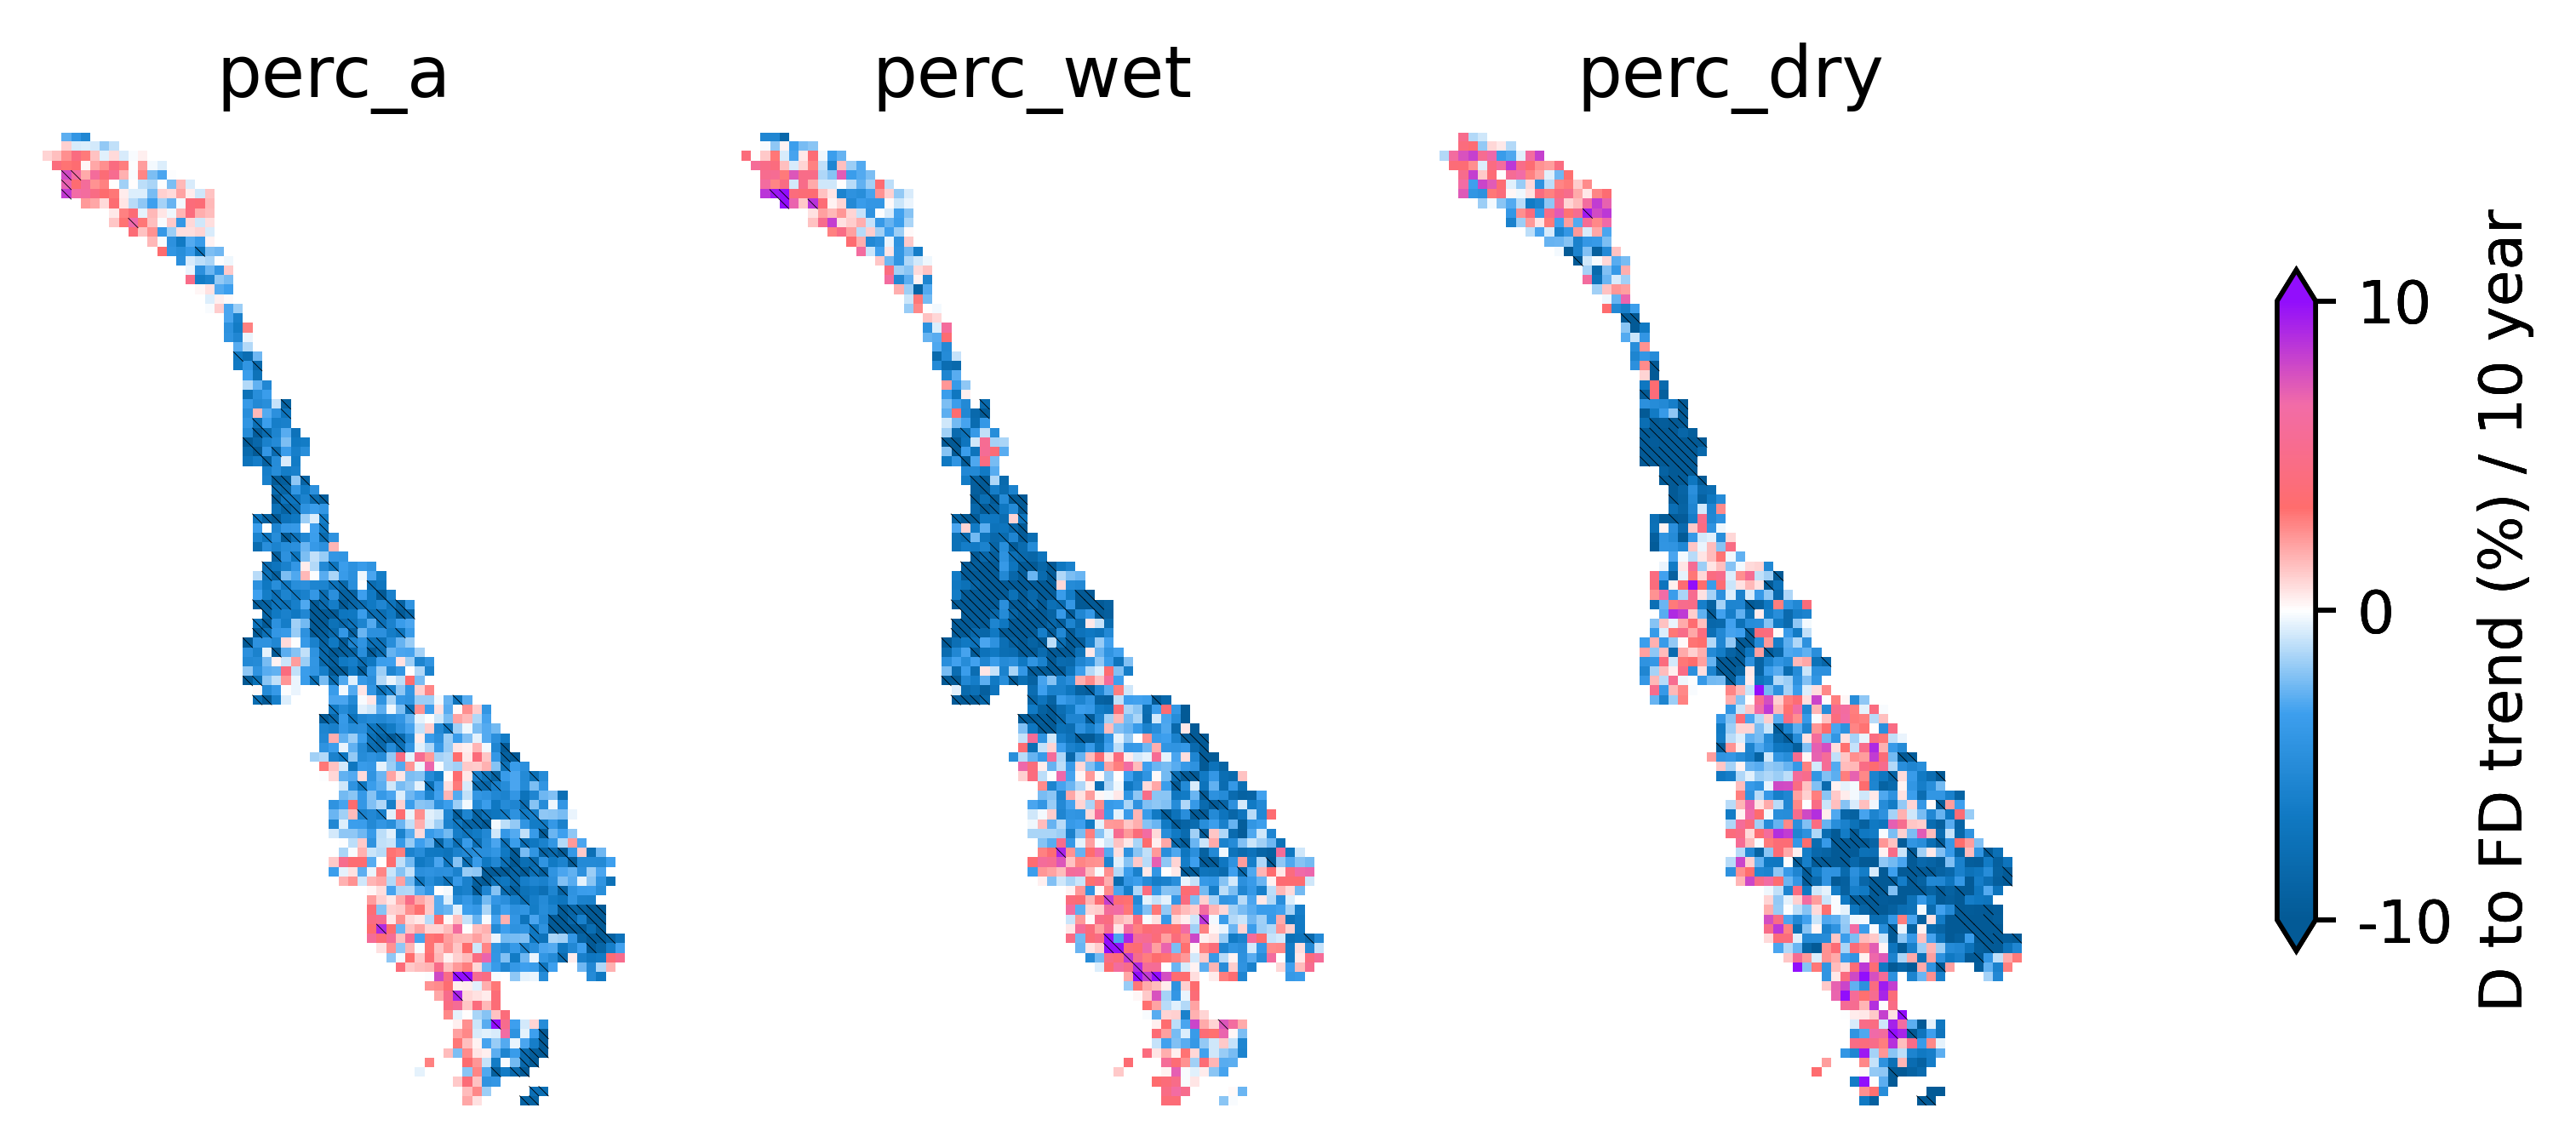

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(6, 4), dpi=500)
images = []

varia6c = [perc_a_co, perc_wet_co,perc_dry_co,]
varia6p = [perc_a_p, perc_wet_p,perc_dry_p,]

for i, (qt, ij, subplot, name) in enumerate(zip(varia6c, varia6p, ax.flat, namess6[6:])):
    im = subplot.imshow(qt*1000, cmap=cmap6, interpolation='nearest',vmin=-10,vmax=10)
    images.append(im)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_frame_on(False)
    #ax[-1, -1].axis('off')
    subplot.set_title(name)
    cax1 = fig.add_axes([1.0, 0.3, 0.015, 0.4]) 
    cbar1 = plt.colorbar(im, cax=cax1, extend='both')
    cbar1.set_label('D to FD trend (%) / 10 year')
    cbar1.set_ticks([-10, 0, 10,])
    cbar1.set_ticklabels(['-10','0', '10',])
    # 显示显著性的对角线网格
    for y in range(ij.shape[0]):
        for x in range(ij.shape[1]):
            if ij[y, x] == 1:
                subplot.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='k',lw=0.12)

In [41]:
import numpy as np

def count_positive_elements(arr):
    positive_count = np.sum(arr < 0)
    return positive_count

# 示例用法
array = np.array([1, -2, 3, 0, -4, 5, 6])
positive_count = count_positive_elements(perc_dry_co)
print("大于0的元素数量：", positive_count)



大于0的元素数量： 880


In [42]:
830/1336

0.6212574850299402

# Correlation of drought_trend and flash_drought_trend 

In [43]:
total_d_trend = d_a_co.reshape(102*61)[~np.isnan(d_a_co.reshape(102*61))] 
wet_d_trend = d_wet_co.reshape(102*61)[~np.isnan(d_wet_co.reshape(102*61))] 
dry_d_trend = d_dry_co.reshape(102*61)[~np.isnan(d_dry_co.reshape(102*61))] 

total_fd_trend = fd_a_co.reshape(102*61)[~np.isnan(fd_a_co.reshape(102*61))] 
wet_fd_trend = fd_wet_co.reshape(102*61)[~np.isnan(fd_wet_co.reshape(102*61))] 
dry_fd_trend = fd_dry_co.reshape(102*61)[~np.isnan(fd_dry_co.reshape(102*61))] 

varia7 = [total_d_trend, wet_d_trend, dry_d_trend, total_fd_trend, wet_fd_trend, dry_fd_trend]

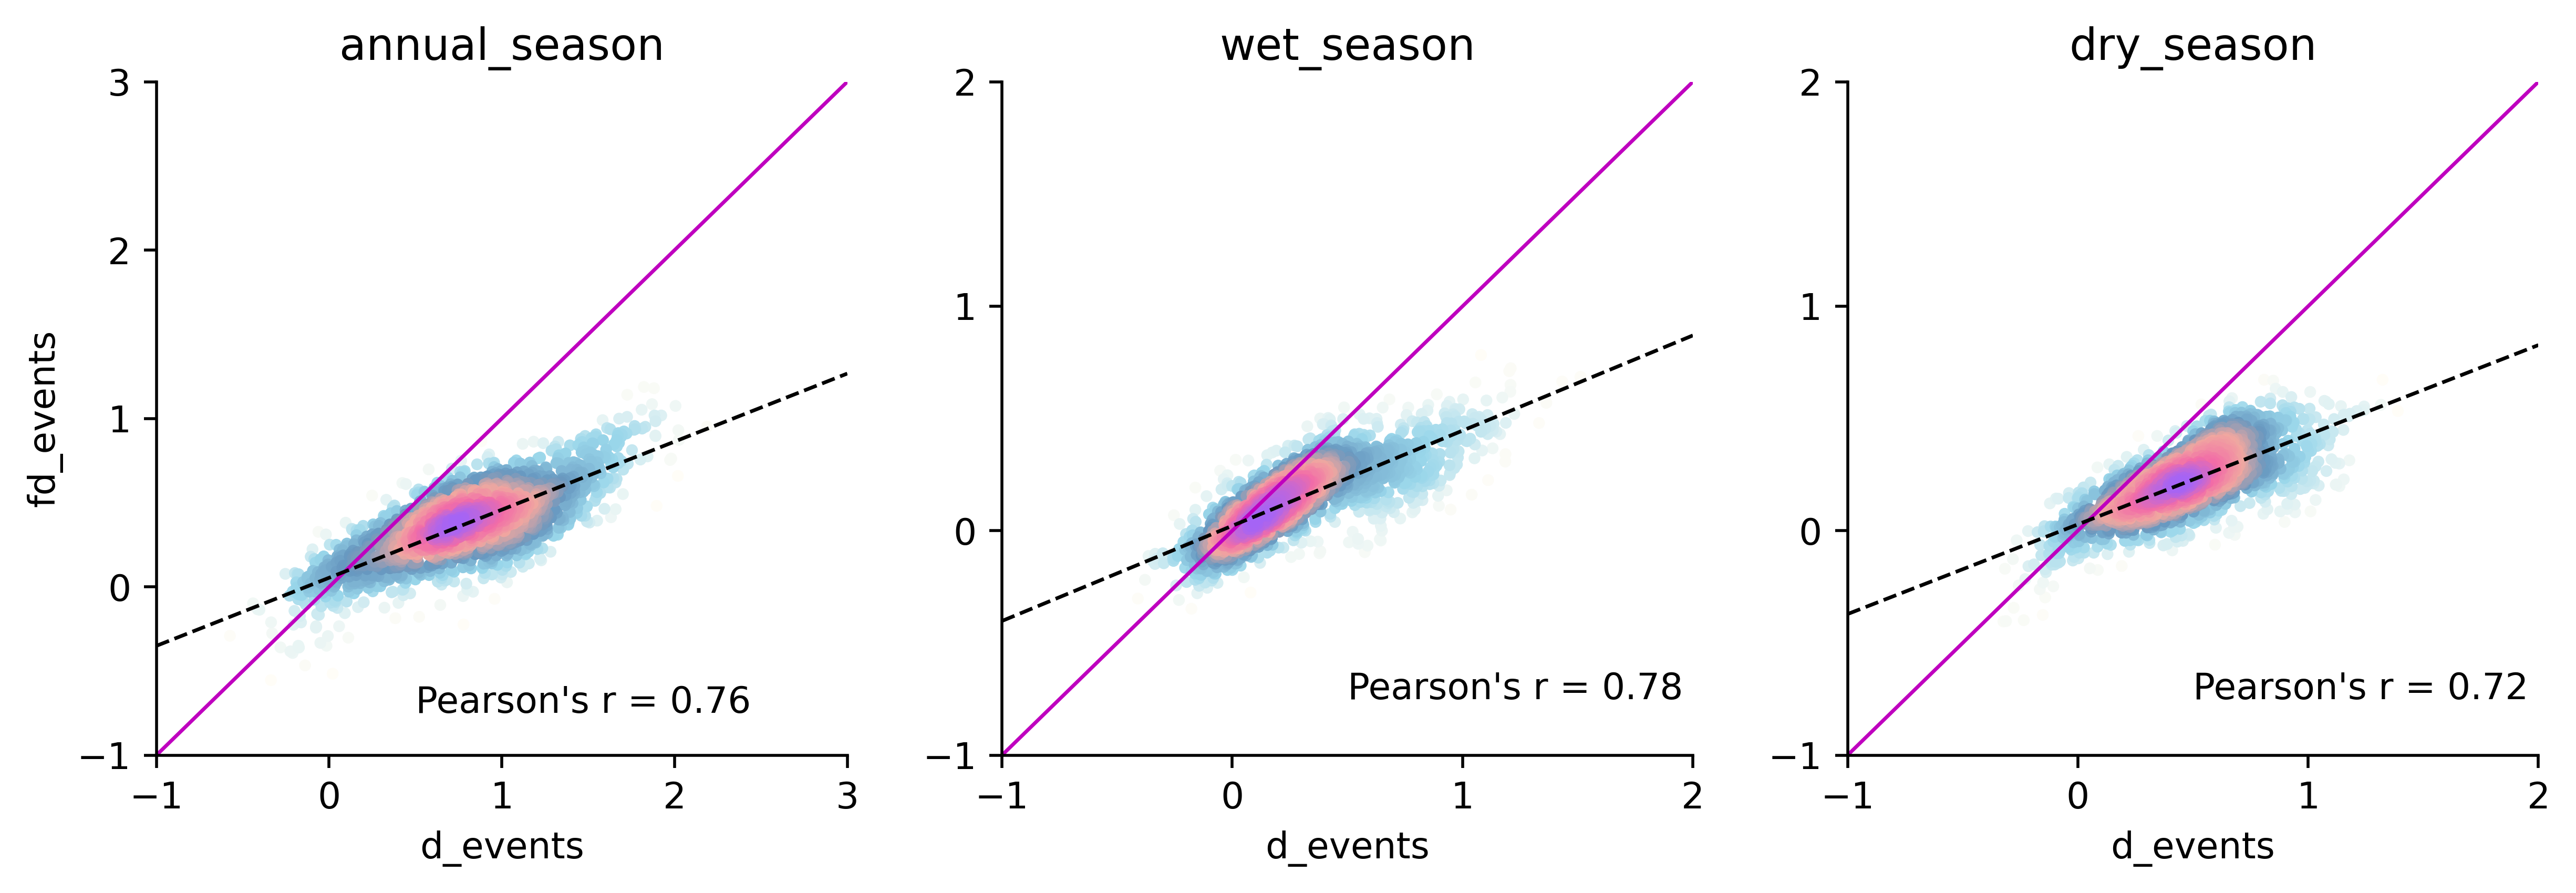

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), dpi=500)
axes[0].set_xlim(-1, 3)
axes[0].set_ylim(-1, 3)
axes[0].set_ylabel('fd_events')

# Set limits for the second plot
axes[1].set_xlim(-1, 2)
axes[1].set_ylim(-1, 2)

# Set limits for the third plot
axes[2].set_xlim(-1, 2)
axes[2].set_ylim(-1, 2)

for i, (data1, data2) in enumerate(zip(varia7[0:3], varia7[3:6])):
    x = data1*10
    y = data2*10

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    r, p = pearsonr(x, y)
    # Plot the scatter plot
    ax = axes[i]
    ax.scatter(x, y, c=z, s=5, cmap=cmap3)
    ax.set_xlabel('d_events')
    ax.plot([-1, ax.get_ylim()[1]], [-1, ax.get_ylim()[1]], 'm-',lw=1)
    
    # ax.text(0.05, 4, f'p-value = {p:.2f}') # Add the p-value to the plot
    x_fit = np.linspace(axes[i].get_xlim()[0], axes[i].get_xlim()[1], num=100)
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    m = model.coef_[0]
    b = model.intercept_
    ax.plot(x_fit, m * x_fit + b, 'k--', label='Fitting Line',lw=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i == 1:
        ax.set_yticks([-1,0, 1, 2])
        ax.set_xticks([-1,0, 1, 2])
        ax.text(0.5,-0.75,f'Pearson\'s r = {r:.2f}')
        ax.set_title('wet_season')
    if i == 2:
        ax.set_yticks([-1,0, 1, 2])
        ax.set_xticks([-1,0, 1, 2])
        ax.text(0.5,-0.75,f'Pearson\'s r = {r:.2f}')
        ax.set_title('dry_season')
    if i == 0:
        ax.set_xticks([-1,0, 1, 2, 3])
        ax.set_yticks([-1,0, 1, 2, 3])
        ax.text(0.5,-0.75,f'Pearson\'s r = {r:.2f}')
        ax.set_title('annual_season')
# Add colorbar to the last plot
# fig.colorbar(ax.collections[0], ax=axes)

plt.tight_layout()
plt.show()

# Role of antecedent meteorological conditions on flash droughts onsetlag (DeltaP and DeltaPET) (to do)